In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
import pandas as pd 
cust=pd.read_csv("olist_customers_dataset.csv")
cust.shape

(99441, 5)

In [3]:
cust.head()
#customerid is unique.To find if one customer has more than one order we need to use the customers table

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
payment=pd.read_csv('olist_order_payments_dataset.csv')
# each row corresponds to a payment method. credit card has more than one installment. 
# boletto - brazillian payment method 

In [5]:
payment.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [6]:
payment['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [7]:
orders=pd.read_csv('olist_orders_dataset.csv')
orders.shape
# rows with same order-id where customer buys more than one product

(99441, 8)

In [8]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [8]:
orders['order_purchase_timestamp'].max()

'2018-10-17 17:30:18'

In [9]:
orders['order_purchase_timestamp'].min()

'2016-09-04 21:15:19'

In [11]:
orders.groupby('order_purchase_timestamp')['customer_id']

In [10]:
classi=pd.read_csv("olist_order_reviews_dataset.csv")

In [11]:
classi.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [12]:
products=pd.read_csv('olist_products_dataset.csv')

In [13]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [14]:
order_item=pd.read_csv('olist_order_items_dataset.csv')

In [15]:
order_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [16]:
cust_od=pd.merge(orders,cust,on='customer_id',how='outer')

In [17]:
cust_od.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [18]:
import pandas as pd 
order_pay=pd.read_csv('olist_order_payments_dataset.csv')

In [19]:
order_pay.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [20]:
reviews=pd.read_csv('olist_order_reviews_dataset.csv')
reviews.head()


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [21]:
reviews.shape

(100000, 7)

In [22]:
reviews.drop('review_comment_title',inplace=True,axis=1)

In [23]:
reviews.isnull().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [24]:
reviews.dropna(inplace=True)

In [25]:
label={}
for i in reviews.review_score:
    if i<=2.5:
        label[i]=0 #negative
    elif i>=2.5:
        label[i]=1 #positive

In [26]:
reviews.review_score=reviews.review_score.map(label)

In [27]:
reviews

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,1,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,1,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,1,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,1,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,1,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01
...,...,...,...,...,...,...
99983,df5fae90e85354241d5d64a8955b2b09,509b86c65fe4e2ad5b96408cfef9755e,1,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00,2018-02-19 19:47:23
99990,a709d176f59bc3af77f4149c96bae357,d5cb12269711bd1eaf7eed8fd32a7c95,1,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00,2018-05-20 21:51:06
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,1,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,0,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [28]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date'],
      dtype='object')

In [29]:
merge= pd.merge(reviews, orders, on='order_id')
merge.shape

(41753, 13)

In [30]:
merge.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [31]:
dataframe=merge.drop(['review_creation_date','review_comment_message','review_answer_timestamp'], axis=1)

In [32]:
dataframe.columns

Index(['review_id', 'order_id', 'review_score', 'customer_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [33]:
merge.isnull().sum()

review_id                           0
order_id                            0
review_score                        0
review_comment_message              0
review_creation_date                0
review_answer_timestamp             0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 107
order_delivered_carrier_date     1234
order_delivered_customer_date    1999
order_estimated_delivery_date       0
dtype: int64

In [34]:
merge.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [35]:
col_time = ['order_purchase_timestamp','order_delivered_carrier_date',
           'order_delivered_customer_date', 'order_estimated_delivery_date','order_approved_at']

In [36]:
for col in col_time:
    dataframe[col] = pd.to_datetime(orders[col])

In [37]:
sellers=pd.read_csv('olist_sellers_dataset.csv')
sellers.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


## Review prediction :

In [38]:
cust.head()
orders.head()
payment.head()
reviews.head()
geo.head()
order_item.head()
products.head()
sellers.head()

NameError: name 'geo' is not defined

In [39]:
merge1=pd.merge(cust,orders,on='customer_id')
merge1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


In [40]:
merge1.shape

(99441, 12)

In [41]:
merge1.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date'],
      dtype='object')

In [42]:
# merge1=merge1[['customer_id','customer_unique_id','customer_zip_code_prefix','customer_city','customer_state'
#               ,'order_id','order_status','order_purchase_timestamp','order_approved_at','order_delivered_customer_date',
#               'order_estimated_delivery_date']]

In [43]:
merge1.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00


In [44]:
merge1.shape

(99441, 12)

In [45]:
order_item.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [46]:
payment.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [47]:
merge2=pd.merge(merge1,payment,on='order_id')
merge2.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')

In [48]:
merge2=merge2.drop(['payment_sequential','payment_type','payment_installments'],axis=1)

In [49]:
merge2.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25


In [50]:
merge2.shape

(103886, 13)

In [51]:
merge3=pd.merge(merge2,order_item,on='order_id')

In [52]:
merge3.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,2017-05-22 15:22:12,124.99,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-01-18 20:58:32,289.00,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,2018-06-05 16:19:10,139.94,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,2018-03-27 16:31:16,149.94,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,2018-07-31 10:10:09,230.00,22.25


In [53]:
merge3.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_value', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value'],
      dtype='object')

In [54]:
merge3=merge3.drop(['price','shipping_limit_date'],axis=1)

In [55]:
merge3.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value,order_item_id,product_id,seller_id,freight_value
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,21.88
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00,335.48,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,46.48
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13 00:00:00,157.73,1,bd07b66896d6f1494f5b86251848ced7,7c67e1448b00f6e969d365cea6b010ab,17.79
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10 00:00:00,173.30,1,a5647c44af977b148e0a3a4751a09e2e,7c67e1448b00f6e969d365cea6b010ab,23.36
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15 00:00:00,252.25,1,9391a573abe00141c56e38d84d7d5b3b,4a3ca9315b744ce9f8e9374361493884,22.25


In [56]:
merge4=pd.merge(merge3,products,on='product_id')

In [57]:
merge4.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,seller_id,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,7c67e1448b00f6e969d365cea6b010ab,21.88,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,7c67e1448b00f6e969d365cea6b010ab,24.90,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,7c67e1448b00f6e969d365cea6b010ab,24.90,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,7c67e1448b00f6e969d365cea6b010ab,15.62,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,7c67e1448b00f6e969d365cea6b010ab,30.59,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0


In [58]:
merge4.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_value', 'order_item_id',
       'product_id', 'seller_id', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm'],
      dtype='object')

In [59]:
merge4=merge4.drop(['product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm'],axis=1)

In [60]:
merge4.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,order_estimated_delivery_date,payment_value,order_item_id,product_id,seller_id,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,...,2017-06-05 00:00:00,146.87,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,21.88,moveis_escritorio,41.0,1141.0,1.0
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,2017-12-19 00:00:00,275.79,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,24.90,moveis_escritorio,41.0,1141.0,1.0
2,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,2017-12-19 00:00:00,275.79,2,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,24.90,moveis_escritorio,41.0,1141.0,1.0
3,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,2017-06-12 00:00:00,140.61,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,15.62,moveis_escritorio,41.0,1141.0,1.0
4,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,2018-03-22 00:00:00,137.58,1,a9516a079e37a9c9c36b9b78b10169e8,7c67e1448b00f6e969d365cea6b010ab,30.59,moveis_escritorio,41.0,1141.0,1.0


In [61]:
reviews.head()

,review_id,order_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,1,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,1,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
9,8670d52e15e00043ae7de4c01cc2fe06,b9bf720beb4ab3728760088589c62129,1,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00,2018-05-23 16:45:47
12,4b49719c8a200003f700d3d986ea1a19,9d6f15f95d01e79bd1349cc208361f09,1,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00,2018-02-20 10:52:22
15,3948b09f7c818e2d86c9a546758b2335,e51478e7e277a83743b6f9991dbfa3fb,1,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00,2018-05-24 03:00:01


In [62]:
merge5=pd.merge(merge4,reviews,on='order_id')

In [63]:
merge5.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,review_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp
0,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,24.90,moveis_escritorio,41.0,1141.0,1.0,7fc63200f12eebb5f387856afdd63db8,0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,24.90,moveis_escritorio,41.0,1141.0,1.0,7fc63200f12eebb5f387856afdd63db8,0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59
2,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,15.62,moveis_escritorio,41.0,1141.0,1.0,251191809e37c1cffc16865947c18a4d,1,"Produto compatível com seu valor, muito bonito...",2017-05-27 00:00:00,2017-05-28 02:43:16
3,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,30.59,moveis_escritorio,41.0,1141.0,1.0,f7123bac5b91a0e2e38d8b41fd1206f4,1,Entregou antes do prazo,2018-03-01 00:00:00,2018-03-02 11:11:24
4,fbd40c083aa8cddebb5265b2ba6aaf2e,f40ab89b622248b7ca125af4b486b887,32341,contagem,MG,e0b26f14d2bcc710bb02f77a4628763b,delivered,2017-05-16 10:00:49,2017-05-17 03:45:27,2017-05-23 10:35:48,...,30.71,moveis_escritorio,41.0,1141.0,1.0,23c661ff382c3a54fc8f98a0b627301f,1,Os encaixes para o encosto da cadeira estavam ...,2017-05-30 00:00:00,2017-05-31 02:54:49


In [64]:
merge5.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   8
order_delivered_carrier_date      842
order_delivered_customer_date    1702
order_estimated_delivery_date       0
payment_value                       0
order_item_id                       0
product_id                          0
seller_id                           0
freight_value                       0
product_category_name             775
product_name_lenght               775
product_description_lenght        775
product_photos_qty                775
review_id                           0
review_score                        0
review_comment_message              0
review_creation_date                0
review_answer_timestamp             0
dtype: int64

In [65]:
merge5.shape

(50665, 26)

In [66]:
merge5.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   8
order_delivered_carrier_date      842
order_delivered_customer_date    1702
order_estimated_delivery_date       0
payment_value                       0
order_item_id                       0
product_id                          0
seller_id                           0
freight_value                       0
product_category_name             775
product_name_lenght               775
product_description_lenght        775
product_photos_qty                775
review_id                           0
review_score                        0
review_comment_message              0
review_creation_date                0
review_answer_timestamp             0
dtype: int64

In [67]:
trans=pd.read_csv("product_category_name_translation.csv")

In [68]:
trans.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [69]:
final=pd.merge(merge5,trans,on='product_category_name')

In [70]:
final.shape

(49878, 27)

In [71]:
final.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_value', 'order_item_id',
       'product_id', 'seller_id', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'review_id', 'review_score',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'product_category_name_english'],
      dtype='object')

In [72]:
final.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,review_id,review_score,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name_english
0,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,moveis_escritorio,41.0,1141.0,1.0,7fc63200f12eebb5f387856afdd63db8,0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59,office_furniture
1,8912fc0c3bbf1e2fbf35819e21706718,9eae34bbd3a474ec5d07949ca7de67c0,68030,santarem,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,...,moveis_escritorio,41.0,1141.0,1.0,7fc63200f12eebb5f387856afdd63db8,0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",2017-11-29 00:00:00,2017-12-01 19:41:59,office_furniture
2,f0ac8e5a239118859b1734e1087cbb1f,3c799d181c34d51f6d44bbbc563024db,92480,nova santa rita,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,...,moveis_escritorio,41.0,1141.0,1.0,251191809e37c1cffc16865947c18a4d,1,"Produto compatível com seu valor, muito bonito...",2017-05-27 00:00:00,2017-05-28 02:43:16,office_furniture
3,6bc8d08963a135220ed6c6d098831f84,23397e992b09769faf5e66f9e171a241,25931,mage,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,...,moveis_escritorio,41.0,1141.0,1.0,f7123bac5b91a0e2e38d8b41fd1206f4,1,Entregou antes do prazo,2018-03-01 00:00:00,2018-03-02 11:11:24,office_furniture
4,fbd40c083aa8cddebb5265b2ba6aaf2e,f40ab89b622248b7ca125af4b486b887,32341,contagem,MG,e0b26f14d2bcc710bb02f77a4628763b,delivered,2017-05-16 10:00:49,2017-05-17 03:45:27,2017-05-23 10:35:48,...,moveis_escritorio,41.0,1141.0,1.0,23c661ff382c3a54fc8f98a0b627301f,1,Os encaixes para o encosto da cadeira estavam ...,2017-05-30 00:00:00,2017-05-31 02:54:49,office_furniture


In [73]:
final_df=final.drop(['product_category_name','product_description_lenght','review_creation_date','review_answer_timestamp'], axis=1)

### Statistical significance

In [74]:
final_df.shape

(49878, 23)

In [75]:
final_df.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   8
order_delivered_carrier_date      814
order_delivered_customer_date    1654
order_estimated_delivery_date       0
payment_value                       0
order_item_id                       0
product_id                          0
seller_id                           0
freight_value                       0
product_name_lenght                 0
product_photos_qty                  0
review_id                           0
review_score                        0
review_comment_message              0
product_category_name_english       0
dtype: int64

In [76]:
final_df.dropna(inplace=True)

In [77]:
final_df.isnull().sum()

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_id                         0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_value                    0
order_item_id                    0
product_id                       0
seller_id                        0
freight_value                    0
product_name_lenght              0
product_photos_qty               0
review_id                        0
review_score                     0
review_comment_message           0
product_category_name_english    0
dtype: int64

In [78]:
final_df.shape

(48216, 23)

In [79]:
sig_df=final_df.select_dtypes(exclude='datetime64[ns]')

In [80]:
sig_df.shape

(48216, 23)

In [81]:
nlp_df=final_df.loc[:,['order_id','review_score','review_comment_message']]

In [82]:
nlp_df

,order_id,review_score,review_comment_message
0,c1d2b34febe9cd269e378117d6681172,0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT..."
1,c1d2b34febe9cd269e378117d6681172,0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT..."
2,b1a5d5365d330d10485e0203d54ab9e8,1,"Produto compatível com seu valor, muito bonito..."
3,2e604b3614664aa66867856dba7e61b7,1,Entregou antes do prazo
4,e0b26f14d2bcc710bb02f77a4628763b,1,Os encaixes para o encosto da cadeira estavam ...
...,...,...,...
49873,9f7ba492c273ffac8f90a623b8eadd3b,1,Excelente
49874,cc9760bf7b5d5b74c4d1eb1ab6405b50,0,Recebi um pacote com apenas um item do que com...
49875,31a2886d02ad2127bfec204da2e93b66,1,"Chegou muito, muito antes do prazo"
49876,2c4ada2e75c2ad41dd93cebb5df5f023,1,Envio muito rápido. Recomendo.


In [83]:
def signinficance(df,X,y,name_of_target_variable):
    import scipy.stats as stats
    from statsmodels.formula.api import ols
    from pandas.api.types import is_string_dtype
    from pandas.api.types import is_datetime64_dtype
    from pandas.api.types import is_float_dtype
    from pandas.api.types import is_int64_dtype
    import statsmodels.api as sm


    sig=[]
    non_sig=[]
    val={}
    Test=[]
    significant=[]
    for i in X.columns:
        if is_datetime64_dtype(X[i]):
            continue
        if is_string_dtype(X[i]):
            tab=pd.crosstab(X[i],y)
            (chisq, p_value, dof, exp) = stats.chi2_contingency(tab)
            val[i]=p_value
            if p_value>0.05:
                non_sig.append(i)
                significant.append('No')
                Test.append('Chi-Square')
            
            else:
                sig.append(i)
                significant.append('Yes')
                Test.append('Chi-Square')

        elif is_float_dtype(X[i]) or is_int64_dtype(X[i]):
            model = ols(f'{i}~{name_of_target_variable}', data = df).fit()
            aov = sm.stats.anova_lm(model, typ=2)
            val[i]=aov.iloc[0,3]
            if aov.iloc[0,3]>0.05:
                non_sig.append(i)
                significant.append('No')
                Test.append('ANOVA')
            else:
                sig.append(i)
                significant.append('Yes')
                Test.append('ANOVA')
    Test=pd.Series(Test, name='Test conducted',index=list(X))
    significant=pd.Series(significant, name='Is_Significance',index=list(X))
    c=pd.DataFrame.from_dict(val,orient='index')
    c.rename(columns={0:'p_val'}, inplace=True)
    table=pd.concat([c,significant,Test], axis=1)
    return sig,non_sig,table

            


    

In [84]:
X=sig_df.drop(['review_score','review_comment_message'],axis=1)
y=final_df.review_score

In [85]:
X.shape

(48216, 21)

In [86]:
sig,non_sig,table=signinficance(sig_df,X,y,'review_score')

In [87]:
table

,p_val,Is_Significance,Test conducted
customer_id,2.025989e-201,Yes,Chi-Square
customer_unique_id,5.524079e-228,Yes,Chi-Square
customer_zip_code_prefix,1.217248e-09,Yes,ANOVA
customer_city,1.197970e-58,Yes,Chi-Square
customer_state,1.852926e-62,Yes,Chi-Square
order_id,2.025989e-201,Yes,Chi-Square
order_status,1.908467e-01,No,Chi-Square
order_purchase_timestamp,1.420663e-204,Yes,Chi-Square
order_approved_at,1.984606e-204,Yes,Chi-Square
order_delivered_carrier_date,1.143017e-228,Yes,Chi-Square


In [88]:
final_df.isnull().sum()

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
order_id                         0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_value                    0
order_item_id                    0
product_id                       0
seller_id                        0
freight_value                    0
product_name_lenght              0
product_photos_qty               0
review_id                        0
review_score                     0
review_comment_message           0
product_category_name_english    0
dtype: int64

In [89]:
final_df.shape

(48216, 23)

In [90]:
nlp_df.shape

(48216, 3)

#### Converting to datetime  : 

In [91]:
final_df.dtypes

customer_id                       object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
payment_value                    float64
order_item_id                      int64
product_id                        object
seller_id                         object
freight_value                    float64
product_name_lenght              float64
product_photos_qty               float64
review_id                         object
review_score                       int64
review_comment_message            object
product_category_name_english     object
dtype: object

### To determine the customer review score: 

#### Dropping few columns : 

In [92]:
final.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'order_id', 'order_status',
       'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'payment_value', 'order_item_id',
       'product_id', 'seller_id', 'freight_value', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'review_id', 'review_score',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'product_category_name_english'],
      dtype='object')

In [93]:
final1=final_df.drop(['customer_id','customer_zip_code_prefix','customer_city'
                  ,'product_id','seller_id','review_id'],axis=1)

In [94]:
final1.head(5)

,customer_unique_id,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_value,order_item_id,freight_value,product_name_lenght,product_photos_qty,review_score,review_comment_message,product_category_name_english
0,9eae34bbd3a474ec5d07949ca7de67c0,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,275.79,1,24.90,41.0,1.0,0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",office_furniture
1,9eae34bbd3a474ec5d07949ca7de67c0,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,275.79,2,24.90,41.0,1.0,0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",office_furniture
2,3c799d181c34d51f6d44bbbc563024db,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12 00:00:00,140.61,1,15.62,41.0,1.0,1,"Produto compatível com seu valor, muito bonito...",office_furniture
3,23397e992b09769faf5e66f9e171a241,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22 00:00:00,137.58,1,30.59,41.0,1.0,1,Entregou antes do prazo,office_furniture
4,f40ab89b622248b7ca125af4b486b887,MG,e0b26f14d2bcc710bb02f77a4628763b,delivered,2017-05-16 10:00:49,2017-05-17 03:45:27,2017-05-23 10:35:48,2017-05-29 12:04:19,2017-06-07 00:00:00,155.70,1,30.71,41.0,1.0,1,Os encaixes para o encosto da cadeira estavam ...,office_furniture


In [95]:
final1=final1.rename({'payment_value':'order_products_value'},axis=1)

In [96]:
final1.head(5)

,customer_unique_id,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_products_value,order_item_id,freight_value,product_name_lenght,product_photos_qty,review_score,review_comment_message,product_category_name_english
0,9eae34bbd3a474ec5d07949ca7de67c0,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,275.79,1,24.90,41.0,1.0,0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",office_furniture
1,9eae34bbd3a474ec5d07949ca7de67c0,PA,c1d2b34febe9cd269e378117d6681172,delivered,2017-11-09 00:50:13,2017-11-10 00:47:48,2017-11-22 01:43:37,2017-11-28 00:09:50,2017-12-19 00:00:00,275.79,2,24.90,41.0,1.0,0,"GOSTARIA DE UMA SOLUÇÃO, ESTOU PRECISANDO MUIT...",office_furniture
2,3c799d181c34d51f6d44bbbc563024db,RS,b1a5d5365d330d10485e0203d54ab9e8,delivered,2017-05-07 20:11:26,2017-05-08 22:22:56,2017-05-19 20:16:31,2017-05-26 09:54:04,2017-06-12 00:00:00,140.61,1,15.62,41.0,1.0,1,"Produto compatível com seu valor, muito bonito...",office_furniture
3,23397e992b09769faf5e66f9e171a241,RJ,2e604b3614664aa66867856dba7e61b7,delivered,2018-02-03 19:45:40,2018-02-04 22:29:19,2018-02-19 18:21:47,2018-02-28 21:09:00,2018-03-22 00:00:00,137.58,1,30.59,41.0,1.0,1,Entregou antes do prazo,office_furniture
4,f40ab89b622248b7ca125af4b486b887,MG,e0b26f14d2bcc710bb02f77a4628763b,delivered,2017-05-16 10:00:49,2017-05-17 03:45:27,2017-05-23 10:35:48,2017-05-29 12:04:19,2017-06-07 00:00:00,155.70,1,30.71,41.0,1.0,1,Os encaixes para o encosto da cadeira estavam ...,office_furniture


In [97]:
final1['review_score'].value_counts()

1    34792
0    13424
Name: review_score, dtype: int64

In [98]:
final1['review_score'].value_counts() / len(final1['review_score'])

1    0.721586
0    0.278414
Name: review_score, dtype: float64

### To check if the proportion is equal : 

In [99]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(final1, test_size=0.2, random_state=42)

In [100]:
test['review_score'].value_counts() / len(test['review_score'])

1    0.728432
0    0.271568
Name: review_score, dtype: float64

### Stratified Split


In [101]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(final1, final1['review_score']):
    strat_train= final1.loc[train_index]
    strat_test= final1.loc[test_index]

In [102]:
strat_train['review_score'].value_counts() / len(strat_train['review_score'])

1.0    0.697501
0.0    0.269029
Name: review_score, dtype: float64

###  Separate target From Features

In [103]:
final1_feat=strat_train.drop('review_score', axis=1)
final1_target= strat_train['review_score'].copy()

### Feature Engineering

In [104]:
corr=strat_train.corr()

In [105]:
corr

,order_products_value,order_item_id,freight_value,product_name_lenght,product_photos_qty,review_score
order_products_value,1.000000,0.306061,0.420569,-0.001636,0.003251,-0.104361
order_item_id,0.306061,1.000000,-0.024518,-0.016621,-0.062522,-0.162170
freight_value,0.420569,-0.024518,1.000000,0.013718,0.023872,-0.029153
product_name_lenght,-0.001636,-0.016621,0.013718,1.000000,0.147193,0.006033
product_photos_qty,0.003251,-0.062522,0.023872,0.147193,1.000000,0.040146
review_score,-0.104361,-0.162170,-0.029153,0.006033,0.040146,1.000000


In [106]:
corr['review_score'].sort_values(ascending=False)

review_score            1.000000
product_photos_qty      0.040146
product_name_lenght     0.006033
freight_value          -0.029153
order_products_value   -0.104361
order_item_id          -0.162170
Name: review_score, dtype: float64

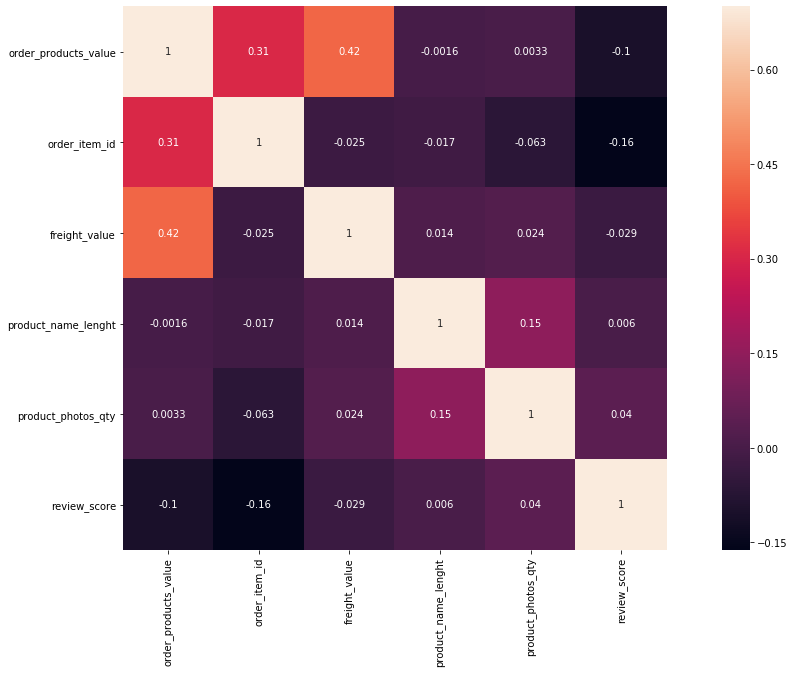

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(20,10))
sns.heatmap(corr,annot=True,vmax=0.7,square=True)
plt.show()

### To consider Brazilian calendar and hollidays


In [108]:
# !pip install workalendar
from workalendar.america import Brazil
cal = Brazil()

In [109]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass    
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df = X.copy()
        
        # Calculate the estimated delivery time and actual delivery time in working days. 
        # This would allow us to exclude hollidays that could influence delivery times.
        # If the order_delivered_customer_date is null, it returns 0.
        df['wd_estimated_delivery_time'] = df.apply(lambda x: cal.get_working_days_delta(x.order_approved_at, 
                                                                                      x.order_estimated_delivery_date), axis=1)
        df['wd_actual_delivery_time'] = df.apply(lambda x: cal.get_working_days_delta(x.order_approved_at, 
                                                                                   x.order_delivered_customer_date), axis=1)

        # Calculate the time between the actual and estimated delivery date. If negative was delivered early, if positive was delivered late.
        df['wd_delivery_time_delta'] = df.wd_actual_delivery_time - df.wd_estimated_delivery_time


        # Calculate the time between the actual and estimated delivery date. If negative was delivered early, if positive was delivered late.
        df['is_late'] = df.order_delivered_customer_date > df.order_estimated_delivery_date
        
        # Calculate the average product value.
        df['average_product_value'] = df.order_products_value / df.order_item_id

        # Calculate the total order value
        df['total_order_value'] = df.order_products_value + df.freight_value
        
        # Calculate the order freight ratio.
#         df['order_freight_ratio'] = df.freight_value / df.order_products_value
        
        # Calculate the order freight ratio.
        df['purchase_dayofweek'] = df.order_purchase_timestamp.dt.dayofweek
                       
        # With that we can remove the timestamps from the dataset
        cols2drop = ['order_purchase_timestamp', 'order_approved_at', 'order_estimated_delivery_date', 
                     'order_delivered_customer_date']
        df.drop(cols2drop, axis=1, inplace=True)
        
        return df

### Executing new features :

In [110]:
col_time = ['order_purchase_timestamp','order_delivered_carrier_date',
           'order_delivered_customer_date', 'order_estimated_delivery_date','order_approved_at']

In [111]:
for col in col_time:
    strat_train[col] = pd.to_datetime(orders[col])

In [112]:
strat_train.dtypes

customer_unique_id                       object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_products_value                    float64
order_item_id                           float64
freight_value                           float64
product_name_lenght                     float64
product_photos_qty                      float64
review_score                            float64
review_comment_message                   object
product_category_name_english            object
dtype: object

In [113]:
attr_adder = AttributesAdder()
feat_eng = attr_adder.transform(strat_train)
feat_eng.head(5)

,customer_unique_id,customer_state,order_id,order_status,order_delivered_carrier_date,order_products_value,order_item_id,freight_value,product_name_lenght,product_photos_qty,review_score,review_comment_message,product_category_name_english,wd_estimated_delivery_time,wd_actual_delivery_time,wd_delivery_time_delta,is_late,average_product_value,total_order_value,purchase_dayofweek
3470,5ceed695eeb968efc7959d859a902e00,SP,e8977f709bbb0367f51b589e6325f991,delivered,2018-07-11 14:23:00,132.51,1.0,36.77,49.0,1.0,1.0,Chegou Chegou antes do prazo tudo correto Gost...,housewares,13,6,-7,False,132.510,169.28,1
9607,fe2b2f70f3dc31c23319ae1029eac77f,GO,7f2c22c54cbae55091a09a9653fd2b8a,delivered,2018-04-24 23:28:44,1048.31,10.0,29.44,40.0,2.0,1.0,Recebi apenas 2 pendentes falta o restante com...,furniture_decor,14,5,-9,False,104.831,1077.75,5
37209,263e9285d676558c0e6ff5d84b2ff4d0,SP,ea74d355b16bf9de1c103719173cb804,delivered,2018-04-26 12:59:00,175.38,2.0,8.51,59.0,1.0,1.0,Otima loja para se comprar\r\nA entrega é rapi...,pet_shop,17,13,-4,False,87.690,183.89,0
31441,facd4e5d86e8a18ac6223047a5f5f07a,SP,cb5fbb27c5009572818e03f9e690edf2,delivered,2018-07-25 14:08:00,117.07,1.0,13.17,27.0,1.0,1.0,OTIMO,watches_gifts,15,7,-8,False,117.070,130.24,1
13858,a5e0123067c49945fbdf028232ad73b0,RS,a5942e5383d5308ba557c96df89cf1c4,delivered,2018-05-21 13:57:00,280.08,2.0,26.55,56.0,1.0,1.0,otima\r\n,auto,18,2,-16,False,140.040,306.63,5


### To find correlation between new features and target:

In [115]:
corr_matrix = feat_eng.corr()
corr_matrix['review_score'].sort_values(ascending=False)

review_score                  1.000000
product_photos_qty            0.040146
wd_delivery_time_delta        0.011538
product_name_lenght           0.006033
wd_actual_delivery_time       0.005777
is_late                       0.003753
purchase_dayofweek           -0.002932
wd_estimated_delivery_time   -0.007200
freight_value                -0.029153
average_product_value        -0.045143
total_order_value            -0.103208
order_products_value         -0.104361
order_item_id                -0.162170
Name: review_score, dtype: float64

### Missing values

In [116]:
feat_eng.isnull().sum()

customer_unique_id               1291
customer_state                   1291
order_id                         1291
order_status                     1291
order_delivered_carrier_date      696
order_products_value             1291
order_item_id                    1291
freight_value                    1291
product_name_lenght              1291
product_photos_qty               1291
review_score                     1291
review_comment_message           1291
product_category_name_english    1291
wd_estimated_delivery_time          0
wd_actual_delivery_time             0
wd_delivery_time_delta              0
is_late                             0
average_product_value            1291
total_order_value                1291
purchase_dayofweek                  0
dtype: int64

In [117]:
feat_eng.dropna(inplace=True)

In [118]:
feat_eng.shape

(36608, 20)

In [119]:
feat_eng.columns

Index(['customer_unique_id', 'customer_state', 'order_id', 'order_status',
       'order_delivered_carrier_date', 'order_products_value', 'order_item_id',
       'freight_value', 'product_name_lenght', 'product_photos_qty',
       'review_score', 'review_comment_message',
       'product_category_name_english', 'wd_estimated_delivery_time',
       'wd_actual_delivery_time', 'wd_delivery_time_delta', 'is_late',
       'average_product_value', 'total_order_value', 'purchase_dayofweek'],
      dtype='object')

In [120]:
nlp_df=feat_eng.loc[:,['order_id','review_score','review_comment_message']]

In [121]:
nlp_df.isnull().sum()

order_id                  0
review_score              0
review_comment_message    0
dtype: int64

In [122]:
nlp_df.shape

(36608, 3)

In [123]:
feat_eng.dtypes

customer_unique_id                       object
customer_state                           object
order_id                                 object
order_status                             object
order_delivered_carrier_date     datetime64[ns]
order_products_value                    float64
order_item_id                           float64
freight_value                           float64
product_name_lenght                     float64
product_photos_qty                      float64
review_score                            float64
review_comment_message                   object
product_category_name_english            object
wd_estimated_delivery_time                int64
wd_actual_delivery_time                   int64
wd_delivery_time_delta                    int64
is_late                                    bool
average_product_value                   float64
total_order_value                       float64
purchase_dayofweek                        int64
dtype: object

In [124]:
feat_eng1=feat_eng.drop(['order_delivered_carrier_date','customer_state','order_id','order_status','product_category_name_english','review_comment_message'],axis=1)

In [125]:
orders_features = strat_train.drop('review_score', axis=1)
orders_labels = strat_train['review_score'].copy()

In [126]:
orders_features['order_purchase_timestamp'] = pd.to_datetime(orders_features.order_purchase_timestamp)
orders_features['order_approved_at'] = pd.to_datetime(orders_features.order_approved_at)
orders_features['order_estimated_delivery_date'] = pd.to_datetime(orders_features.order_estimated_delivery_date)  
orders_features['order_delivered_customer_date'] = pd.to_datetime(orders_features.order_delivered_customer_date)
# orders_features.drop('shipping_limit_date',axis=1,inplace=True)

In [127]:
# selecting the numerical and text attributes
cat_attribs = ['customer_unique_id','order_status', 'customer_state', 'product_category_name_english','order_id','review_comment_message']
num_attribs = orders_features.drop(cat_attribs, axis=1).columns

In [128]:
num_attribs

Index(['order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'order_products_value',
       'order_item_id', 'freight_value', 'product_name_lenght',
       'product_photos_qty'],
      dtype='object')

In [129]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.attribute_names]

In [130]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# for now we wont work with categorical data. Planning to add it on next releases
num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
                         ('attribs_adder', AttributesAdder())
                        ])

In [131]:
orders_features.drop(['customer_state','order_id','order_status'],axis=1,inplace=True)

In [132]:
orders_features.drop('product_category_name_english',axis=1,inplace=True)

In [133]:
orders_features.drop('customer_unique_id',axis=1,inplace=True)


In [134]:
orders_features.drop('review_comment_message',axis=1,inplace=True)

In [135]:
orders_features.dtypes

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_products_value                    float64
order_item_id                           float64
freight_value                           float64
product_name_lenght                     float64
product_photos_qty                      float64
dtype: object

In [136]:
orders_features_prepared = num_pipeline.fit_transform(orders_features)
orders_features_prepared

,order_delivered_carrier_date,order_products_value,order_item_id,freight_value,product_name_lenght,product_photos_qty,wd_estimated_delivery_time,wd_actual_delivery_time,wd_delivery_time_delta,is_late,average_product_value,total_order_value,purchase_dayofweek
3470,2018-07-11 14:23:00,132.51,1.0,36.77,49.0,1.0,13,6,-7,False,132.510,169.28,1
9607,2018-04-24 23:28:44,1048.31,10.0,29.44,40.0,2.0,14,5,-9,False,104.831,1077.75,5
37209,2018-04-26 12:59:00,175.38,2.0,8.51,59.0,1.0,17,13,-4,False,87.690,183.89,0
31441,2018-07-25 14:08:00,117.07,1.0,13.17,27.0,1.0,15,7,-8,False,117.070,130.24,1
13858,2018-05-21 13:57:00,280.08,2.0,26.55,56.0,1.0,18,2,-16,False,140.040,306.63,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15577,2018-02-06 00:17:20,37.78,1.0,12.79,40.0,1.0,16,10,-6,False,37.780,50.57,4
46464,2017-08-01 13:44:56,32.38,1.0,7.39,40.0,2.0,18,9,-9,False,32.380,39.77,5
29011,2018-01-19 21:52:17,368.60,1.0,28.70,59.0,1.0,11,2,-9,False,368.600,397.30,3
40581,2017-06-28 11:50:05,72.77,1.0,7.78,59.0,2.0,15,5,-10,False,72.770,80.55,1


In [137]:
orders_features_prepared.isnull().sum()

order_delivered_carrier_date     696
order_products_value            1291
order_item_id                   1291
freight_value                   1291
product_name_lenght             1291
product_photos_qty              1291
wd_estimated_delivery_time         0
wd_actual_delivery_time            0
wd_delivery_time_delta             0
is_late                            0
average_product_value           1291
total_order_value               1291
purchase_dayofweek                 0
dtype: int64

In [138]:
orders_features_prepared.dropna(inplace=True)

In [139]:
orders_features_prepared.shape

(36608, 13)

In [140]:
from sklearn.preprocessing import StandardScaler

In [141]:
sc=StandardScaler()

In [142]:
late={}
for i in orders_features_prepared.is_late:
    if i==True:
        late[i]=1
    elif i==False:
        
        late[i]=0

In [143]:
late

{False: 0, True: 1}

In [144]:
orders_features_prepared.is_late=orders_features_prepared.is_late.map(late)

In [145]:
import numpy as np

In [146]:
orders_features_prepared.drop('order_delivered_carrier_date',inplace=True,axis=1)

In [147]:
feature_names=list(orders_features_prepared.columns)

In [148]:
orders_features_prepared.shape
orders_labels.shape

(38572,)

In [149]:
orders_features_prepared=sc.fit_transform(orders_features_prepared)

In [150]:
# X=feat_eng1.drop('review_score',axis=1)
# y=feat_eng1['review_score']
orders_labels=nlp_df.review_score

In [151]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(orders_features_prepared,orders_labels, test_size = 0.30, random_state = 1)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)


(25625, 12)
(10983, 12)
(10983,)


In [ ]:
#SMOTE

In [ ]:
# from imblearn.over_sampling import SMOTE
# smote=SMOTE('minority')

In [ ]:
# x_sm,y_sm=smote.fit_sample(X_train,y_train)

In [ ]:
# y_sm.value_counts()/y_sm.shape[0]

In [ ]:
# feature_names.pop(0)

In [152]:
rf=RandomForestClassifier(n_estimators=100)


In [153]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100)

rf.fit(X_train,y_train)
y_pred=rf.predict(X_test) 



rf= RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

rf.fit(X_train,y_train)
feature_names
import pandas as pd
feature_imp = pd.Series(rf.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp


freight_value                 0.131383
total_order_value             0.130927
order_products_value          0.127115
average_product_value         0.123500
product_name_lenght           0.101718
wd_estimated_delivery_time    0.087882
wd_delivery_time_delta        0.086960
wd_actual_delivery_time       0.082372
purchase_dayofweek            0.060563
product_photos_qty            0.036412
order_item_id                 0.026731
is_late                       0.004436
dtype: float64

In [154]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [155]:
rf.score(X_train,y_train)

0.999960975609756

In [156]:
from sklearn import metrics
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.54      0.17      0.26      3034
         1.0       0.75      0.94      0.83      7949

    accuracy                           0.73     10983
   macro avg       0.64      0.56      0.55     10983
weighted avg       0.69      0.73      0.68     10983



In [157]:
freight_value                 0.131383
total_order_value             0.130927
order_products_value          0.127115
average_product_value         0.123500
product_name_lenght           0.101718

3470     1.0
9607     1.0
37209    1.0
31441    1.0
13858    1.0
        ... 
15577    1.0
46464    1.0
29011    1.0
40581    1.0
10672    1.0
Name: review_score, Length: 36608, dtype: float64

In [158]:
X=feat_eng1.drop(['wd_actual_delivery_time','customer_unique_id','wd_delivery_time_delta','wd_estimated_delivery_time','purchase_dayofweek','product_photos_qty'\
                                ,'order_item_id','is_late','review_score'],axis=1)
y=orders_labels

In [159]:
X.dtypes

order_products_value     float64
freight_value            float64
product_name_lenght      float64
average_product_value    float64
total_order_value        float64
dtype: object

In [160]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.30, random_state = 1)

In [161]:
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [162]:
# rf.fit(X_train,y_train)

In [163]:
# pred=rf.predict(X_test)

In [164]:
def get_best_model(estimator, params_grid={}):
    from sklearn.model_selection import GridSearchCV

    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(X_train,y_train)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [166]:
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
'max_depth':[10],
'max_features':[2,3,4,5],
'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)


--- Best Parameters -----------------------------
{'max_depth': 10, 'max_features': 3, 'min_samples_split': 11, 'n_estimators': 100}

--- Best Model -----------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


In [167]:
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [168]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [169]:
rf.score(X_train,y_train)

0.7622243902439024

In [170]:
pred=rf.predict(X_test)

In [171]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.61      0.12      0.20      3034
         1.0       0.74      0.97      0.84      7949

    accuracy                           0.74     10983
   macro avg       0.68      0.55      0.52     10983
weighted avg       0.71      0.74      0.67     10983



In [172]:

from sklearn.naive_bayes import GaussianNB
model=GaussianNB()


In [173]:
model.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [174]:
model.score(X_train,y_train)

0.7026731707317073

In [175]:
pred=model.predict(X_test)

In [176]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.36      0.10      0.15      3034
         1.0       0.73      0.93      0.82      7949

    accuracy                           0.70     10983
   macro avg       0.55      0.52      0.49     10983
weighted avg       0.63      0.70      0.64     10983



In [177]:
from sklearn.neighbors import KNeighborsClassifier

In [178]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[5,6,7],
'p':[1,2],
'weights':['uniform','distance']}
clf_knn = get_best_model(knn,parameters)



--- Best Parameters -----------------------------
{'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}

--- Best Model -----------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=1,
                     weights='uniform')


In [179]:
knn=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=1,
                     weights='distance')

In [180]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=1,
                     weights='distance')

In [181]:
knn.score(X_train,y_train)

0.9710048780487804

In [182]:
pred=knn.predict(X_test)

In [183]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.41      0.27      0.33      3034
         1.0       0.75      0.85      0.80      7949

    accuracy                           0.69     10983
   macro avg       0.58      0.56      0.56     10983
weighted avg       0.66      0.69      0.67     10983



In [184]:
ada=AdaBoostClassifier(n_estimators=500, learning_rate=0.75)

In [185]:
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.75,
                   n_estimators=500, random_state=None)

In [186]:
ada.score(X_train,y_train)

0.7316682926829269

In [187]:
X_train.shape

(25625, 5)

In [188]:
pred=ada.predict(X_test)

In [189]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.59      0.10      0.16      3034
         1.0       0.74      0.97      0.84      7949

    accuracy                           0.73     10983
   macro avg       0.67      0.54      0.50     10983
weighted avg       0.70      0.73      0.65     10983



In [190]:
sv=SVC(kernel='linear',C=0.02)

In [191]:
sv.fit(X_train,y_train)

SVC(C=0.02, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [192]:
sv.score(X_train,y_train)

0.7224975609756098

In [193]:
pred=sv.predict(X_test)

In [194]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

         0.0       0.69      0.01      0.02      3034
         1.0       0.73      1.00      0.84      7949

    accuracy                           0.73     10983
   macro avg       0.71      0.50      0.43     10983
weighted avg       0.71      0.73      0.61     10983



# NLP

In [207]:
sent=nlp_df.copy()

In [ ]:
# # Put in our parameters for said classifiers
# # Random Forest parameters
# rf_params = {
#     'n_jobs': -1,
#     'n_estimators': 500,
#      'warm_start': True, 
#      #'max_features': 0.2,
#     'max_depth': 6,
#     'min_samples_leaf': 2,
#     'max_features' : 'sqrt',
#     'verbose': 0
# }

# # Extra Trees Parameters
# et_params = {
#     'n_jobs': -1,
#     'n_estimators':500,
#     #'max_features': 0.5,
#     'max_depth': 8,
#     'min_samples_leaf': 2,
#     'verbose': 0
# }

# # AdaBoost parameters
# ada_params = {
#     'n_estimators': 500,
#     'learning_rate' : 0.75
# }

# # Gradient Boosting parameters
# gb_params = {
#     'n_estimators': 500,
#      #'max_features': 0.2,
#     'max_depth': 5,
#     'min_samples_leaf': 2,
#     'verbose': 0
# }

# # Support Vector Classifier parameters 
# svc_params = {
#     'kernel' : 'linear',
#     'C' : 0.025
#     }

In [208]:
sent.review_comment_message=sent.review_comment_message.str.lower()

In [209]:
sent

,order_id,review_score,review_comment_message
3470,e8977f709bbb0367f51b589e6325f991,1.0,chegou chegou antes do prazo tudo correto gost...
9607,7f2c22c54cbae55091a09a9653fd2b8a,1.0,recebi apenas 2 pendentes falta o restante com...
37209,ea74d355b16bf9de1c103719173cb804,1.0,otima loja para se comprar\r\na entrega é rapi...
31441,cb5fbb27c5009572818e03f9e690edf2,1.0,otimo
13858,a5942e5383d5308ba557c96df89cf1c4,1.0,otima\r\n
...,...,...,...
15577,40f6e7101c9bdc9aa16832f25ee7ee2c,1.0,compra chegou rápida e conforme o combinado.
46464,13ccf8b8e58a45adbc06ffb651474fdf,1.0,a entrega foi feita em menos de 48h isso pq fi...
29011,89d881134bb068f04011771181b2cb86,1.0,no meu status consta como cancelado ( pois sol...
40581,79347dc228cde031ba95adb6a647ab6b,1.0,amei


In [210]:
import re

In [211]:
import string
from nltk.tokenize import word_tokenize
review_lines=list()
lines=sent.review_comment_message.values.tolist()
for i in lines:
    tokens=word_tokenize(i)
    tokens=[w.lower() for w in tokens]
    table=str.maketrans('','',string.punctuation)
    stripped=[w.translate(table) for w in tokens]
    words=[word for word in stripped if word.isalpha()]
    review_lines.append(words)
series=pd.Series(review_lines)

In [212]:
sent.reset_index(inplace=True)
sent.drop('index',inplace=True,axis=1)

In [213]:
sent

,order_id,review_score,review_comment_message
0,e8977f709bbb0367f51b589e6325f991,1.0,chegou chegou antes do prazo tudo correto gost...
1,7f2c22c54cbae55091a09a9653fd2b8a,1.0,recebi apenas 2 pendentes falta o restante com...
2,ea74d355b16bf9de1c103719173cb804,1.0,otima loja para se comprar\r\na entrega é rapi...
3,cb5fbb27c5009572818e03f9e690edf2,1.0,otimo
4,a5942e5383d5308ba557c96df89cf1c4,1.0,otima\r\n
...,...,...,...
36603,40f6e7101c9bdc9aa16832f25ee7ee2c,1.0,compra chegou rápida e conforme o combinado.
36604,13ccf8b8e58a45adbc06ffb651474fdf,1.0,a entrega foi feita em menos de 48h isso pq fi...
36605,89d881134bb068f04011771181b2cb86,1.0,no meu status consta como cancelado ( pois sol...
36606,79347dc228cde031ba95adb6a647ab6b,1.0,amei


In [214]:
for i in range(len(series)):
    series[i] = ' '.join(series[i])

sent['n_tidy'] = series

In [215]:
sent

,order_id,review_score,review_comment_message,n_tidy
0,e8977f709bbb0367f51b589e6325f991,1.0,chegou chegou antes do prazo tudo correto gost...,chegou chegou antes do prazo tudo correto gost...
1,7f2c22c54cbae55091a09a9653fd2b8a,1.0,recebi apenas 2 pendentes falta o restante com...,recebi apenas pendentes falta o restante com u...
2,ea74d355b16bf9de1c103719173cb804,1.0,otima loja para se comprar\r\na entrega é rapi...,otima loja para se comprar a entrega é rapida ...
3,cb5fbb27c5009572818e03f9e690edf2,1.0,otimo,otimo
4,a5942e5383d5308ba557c96df89cf1c4,1.0,otima\r\n,otima
...,...,...,...,...
36603,40f6e7101c9bdc9aa16832f25ee7ee2c,1.0,compra chegou rápida e conforme o combinado.,compra chegou rápida e conforme o combinado
36604,13ccf8b8e58a45adbc06ffb651474fdf,1.0,a entrega foi feita em menos de 48h isso pq fi...,a entrega foi feita em menos de isso pq fiz o ...
36605,89d881134bb068f04011771181b2cb86,1.0,no meu status consta como cancelado ( pois sol...,no meu status consta como cancelado pois solic...
36606,79347dc228cde031ba95adb6a647ab6b,1.0,amei,amei


In [216]:
import spacy
nlp=spacy.load('pt_core_news_sm')

In [217]:
tokens=sent['n_tidy']

In [218]:
for i in range(len(tokens)):
    tokens[i]=nlp(tokens[i])

In [219]:
tokens_1 = tokens.apply(lambda x: [i.lemma_ for i in x]) # lemmatization
# lemmatization

In [220]:
for i in range(len(tokens_1)):
    tokens_1[i] = ' '.join(tokens_1[i])

sent['n_tidy'] = tokens_1

In [222]:
sent

,order_id,review_score,review_comment_message,n_tidy
0,e8977f709bbb0367f51b589e6325f991,1.0,chegou chegou antes do prazo tudo correto gost...,chegar chegar antar do prazo tudo corretar gos...
1,7f2c22c54cbae55091a09a9653fd2b8a,1.0,recebi apenas 2 pendentes falta o restante com...,receber apenas pendente falto o restante com u...
2,ea74d355b16bf9de1c103719173cb804,1.0,otima loja para se comprar\r\na entrega é rapi...,otima loja parir se comprar o entregar ser rap...
3,cb5fbb27c5009572818e03f9e690edf2,1.0,otimo,otimo
4,a5942e5383d5308ba557c96df89cf1c4,1.0,otima\r\n,otima
...,...,...,...,...
36603,40f6e7101c9bdc9aa16832f25ee7ee2c,1.0,compra chegou rápida e conforme o combinado.,comprar chegar rápido e conformar o combinar
36604,13ccf8b8e58a45adbc06ffb651474fdf,1.0,a entrega foi feita em menos de 48h isso pq fi...,o entregar ser feito em menos de isso pq fazer...
36605,89d881134bb068f04011771181b2cb86,1.0,no meu status consta como cancelado ( pois sol...,o meu status constar comer cancelar pois solic...
36606,79347dc228cde031ba95adb6a647ab6b,1.0,amei,amar


In [357]:
review_lines

[['produto',
  'bom',
  'e',
  'chegou',
  'antes',
  'do',
  'prazo',
  'previstoestou',
  'muito',
  'satisfeita'],
 ['dentro', 'do', 'prazo'],
 ['boa'],
 ['produto',
  'muito',
  'bonito',
  'chegou',
  'no',
  'prazo',
  'correto',
  'parece',
  'um',
  'trofeu',
  'qualidade',
  'ótimo',
  'para',
  'presente'],
 ['entrega', 'rapidinha'],
 ['infelizmente', 'ainda', 'não', 'recebi', 'a', 'mercadoria'],
 ['fiz',
  'uma',
  'compra',
  'de',
  'duas',
  'garrafas',
  'super',
  'caras',
  'recebi',
  'apenas',
  'uma',
  'e',
  'o',
  'principal',
  'o',
  'filtro',
  'de',
  'quase',
  'reais',
  'não',
  'vieram',
  'estar',
  'no',
  'meu',
  'email',
  'como',
  'entregue',
  'so',
  'tento',
  'recebido',
  'uma',
  'garrafa',
  'gostaria',
  'resp'],
 ['perfeito', 'tudo', 'ok'],
 ['comprei',
  'pela',
  'segunda',
  'vez',
  'e',
  'ainda',
  'não',
  'recebi',
  'parceiro',
  'das',
  'lojas',
  'lannister',
  'não',
  'informa',
  'o',
  'cliente',
  'sobre',
  'emissão',
  '

In [358]:
reviews = sent.n_tidy.str.cat(sep=' ')


In [359]:
reviews

'produto bom e chegar antar do prazo previstoestou muito satisfeito dentro do prazo bom produto muito bonito chegar o prazo corretar parecer um troféu qualidade ótimo parir presentar entregar rapidinha infelizmente ainda não receber o mercadoria fazer umar comprar de dois garrafa super caro receber apenas umar e o principal o filtrar de quase real não vir estar o meu email comer entregar so tentar receber umar garrafa gostar resp perfazer tudo ok comprar pelar segundo vez e ainda não receber parceiro das loja lannister não informar o cliente sobrar emissão de nf e o entregar ter que ficar cobrar status do processar gostar muito estar de parabém recomendar o lojatop tudo ok entregar antar do prazo o encomendar chegar antar do prazo muito bom o panela ser ótima produto não ser bom muito bom recomendar tudo ok já reclamar referente o meu produto que vir errar e até agora ninguém me retornar só umar das canaletas que não vir perfurar e não conseguir encaixar direito produto dar de o em rel

In [223]:
EMBEDDING_DIM=400

In [224]:
#using word2vec model
import gensim


In [225]:
model=gensim.models.Word2Vec(sentences=review_lines,size=EMBEDDING_DIM, window=5,min_count=1)

In [226]:
words=list(model.wv.vocab)

In [227]:
import logging


In [228]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.wv.vocab:
            mean.append(wv.wv.syn0[wv.wv.vocab[word].index])
            all_words.add(wv.wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [229]:
word_averaging_list(model,words)

array([[ 0.06139355, -0.03989128, -0.00120545, ...,  0.02105562,
        -0.02686688,  0.02206599],
       [ 0.01779796, -0.05255923, -0.02534939, ...,  0.00658321,
         0.00167139, -0.00979437],
       [ 0.07253198, -0.04123199,  0.0065205 , ...,  0.02275927,
        -0.03018228,  0.06848407],
       ...,
       [ 0.0434927 , -0.04919565, -0.020794  , ...,  0.02507281,
        -0.01561689,  0.01981212],
       [ 0.04477279, -0.04905951, -0.01066112, ...,  0.00983313,
        -0.01538189,  0.00563625],
       [ 0.02842071, -0.06084183, -0.03975283, ...,  0.02890641,
        -0.00439526, -0.01316756]], dtype=float32)

In [230]:
import nltk
from nltk.tokenize import word_tokenize

In [231]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

In [232]:
df=sent.loc[:,['n_tidy','review_score']]

In [233]:
from sklearn.model_selection import train_test_split

In [234]:
train, test = train_test_split(df, test_size=0.3, random_state = 1)



In [235]:
train.review_score

5795     0.0
6857     1.0
35301    0.0
11344    0.0
5375     1.0
        ... 
7813     1.0
32511    1.0
5192     1.0
12172    1.0
33003    1.0
Name: review_score, Length: 25625, dtype: float64

In [236]:
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['n_tidy']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['n_tidy']), axis=1).values

X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

In [237]:
X_train_word_average.shape

(25625, 400)

In [238]:
def get_best_model(estimator, params_grid={}):
    from sklearn.model_selection import GridSearchCV

    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(X_train_word_average,train.review_score)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [239]:
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
'max_depth':[10],
'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)


--- Best Parameters -----------------------------
{'max_depth': 10, 'min_samples_split': 11, 'n_estimators': 100}

--- Best Model -----------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


In [240]:
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [241]:
rf.fit(X_train_word_average,train.review_score)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [242]:
rf.score(X_train_word_average,train.review_score)

0.922029268292683

In [243]:
nlp_pred=rf.predict(X_test_word_average)

In [244]:
nlp_pred_rf=pd.Series(nlp_pred,name='rf_NLP_pred')

In [245]:
print(metrics.classification_report(test.review_score,nlp_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.81      0.77      3034
         1.0       0.92      0.89      0.91      7949

    accuracy                           0.87     10983
   macro avg       0.83      0.85      0.84     10983
weighted avg       0.87      0.87      0.87     10983



In [246]:
sv.fit(X_train_word_average,train.review_score)

SVC(C=0.02, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [247]:
sv.score(X_train_word_average,train.review_score)

0.8410146341463415

In [248]:
svc_nlp_pred=sv.predict(X_test_word_average)

In [249]:
svc_nlp_pred=pd.Series(svc_nlp_pred,name='svc_nlp_pred')

In [250]:
print(metrics.classification_report(test.review_score,svc_nlp_pred)) 

              precision    recall  f1-score   support

         0.0       0.69      0.74      0.71      3034
         1.0       0.90      0.87      0.88      7949

    accuracy                           0.84     10983
   macro avg       0.79      0.81      0.80     10983
weighted avg       0.84      0.84      0.84     10983



In [251]:
ada.fit(X_train_word_average,train.review_score)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.75,
                   n_estimators=500, random_state=None)

In [252]:
ada.score(X_train_word_average,train.review_score)

0.8900682926829269

In [253]:
ada_nlp_pred=ada.predict(X_test_word_average)

In [254]:
ada_nlp_pred=pd.Series(ada_nlp_pred,name='ada_nlp_pred')

In [255]:
print(metrics.classification_report(test.review_score,ada_nlp_pred))

              precision    recall  f1-score   support

         0.0       0.74      0.77      0.75      3034
         1.0       0.91      0.90      0.90      7949

    accuracy                           0.86     10983
   macro avg       0.82      0.83      0.83     10983
weighted avg       0.86      0.86      0.86     10983



In [389]:
print(metrics.classification_report(test.review_score,ada_nlp_pred))

              precision    recall  f1-score   support

         1.0       0.57      0.82      0.67      2422
         2.0       0.30      0.05      0.08       668
         3.0       0.25      0.08      0.12       986
         4.0       0.26      0.10      0.14      1558
         5.0       0.73      0.88      0.80      5339

    accuracy                           0.64     10973
   macro avg       0.42      0.39      0.36     10973
weighted avg       0.56      0.64      0.57     10973



## Now lets try a stacking Classifier


In [256]:
X=feat_eng1.drop(['customer_unique_id','wd_delivery_time_delta','wd_estimated_delivery_time','purchase_dayofweek','product_photos_qty'\
                                ,'order_item_id','is_late','review_score'],axis=1)
y=orders_labels

In [257]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [258]:
rf_pred=rf.predict(X_test)

In [259]:
rf_pred=pd.Series(rf_pred,name='RF_Pred')

In [260]:
sv.fit(X_train,y_train)

SVC(C=0.02, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [261]:
svc_pred=sv.predict(X_test)

In [262]:
svc_pred=pd.Series(svc_pred,name='SVC_Pred')

In [263]:
ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.75,
                   n_estimators=500, random_state=None)

In [264]:
ada_pred=ada.predict(X_test)

In [265]:
ada_pred=pd.Series(ada_pred,name='ADA_Pred')

In [266]:
stack_df=pd.DataFrame()

In [267]:
stack_df=pd.concat([rf_pred,svc_pred,ada_pred,nlp_pred_rf,svc_nlp_pred,ada_nlp_pred],axis=1)

In [275]:
def get_best_model(estimator, params_grid={}):
    from sklearn.model_selection import GridSearchCV

    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(stack_df,test.review_score)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [278]:
import xgboost as xgb
xgb = xgb.XGBClassifier()
parameters={'n_estimators':[900,1000,1100],
'num_class':[2],
'learning_rate':[0.01],
'max_depth':[8],
'min_child_weight':[1],
'subsample':[0.8],
'colsample_bytree':[0.3,0.4,0.5]}

In [280]:
# stack_1=get_best_model(xgb,parameters)

In [281]:
import xgboost as xgb

xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [273]:
import xgboost as xgb
xgb=xgb.XGBClassifier()

,RF_Pred,SVC_Pred,ADA_Pred,rf_NLP_pred,svc_nlp_pred,ada_nlp_pred
0,1.0,1.0,1.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...
10978,1.0,1.0,1.0,1.0,1.0,1.0
10979,1.0,1.0,1.0,1.0,1.0,1.0
10980,1.0,1.0,1.0,1.0,1.0,1.0
10981,1.0,1.0,1.0,1.0,1.0,1.0


In [282]:
xgb.fit(stack_df,test.review_score)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [283]:
xgb.score(stack_df,test.review_score)

0.8681598834562506

In [284]:
pred_stack=xgb.predict(stack_df)

In [285]:
print(metrics.classification_report(test.review_score,pred_stack))

              precision    recall  f1-score   support

         0.0       0.77      0.74      0.76      3034
         1.0       0.90      0.92      0.91      7949

    accuracy                           0.87     10983
   macro avg       0.84      0.83      0.83     10983
weighted avg       0.87      0.87      0.87     10983



In [286]:
test.review_score.value_counts()/test.shape[0]

1.0    0.723755
0.0    0.276245
Name: review_score, dtype: float64

## Due to the Imbalance in the dataset the model cannot accurately predict class 2,3,4 is very low so let us try SMOTE

In [287]:
from imblearn.over_sampling import SMOTE
smote=SMOTE('minority')

In [288]:
x_sm,y_sm=smote.fit_sample(X_train,y_train)

In [289]:
x_sm.shape

(36962, 5)

In [290]:
y_sm.value_counts()/y_sm.shape[0]

1.0    0.5
0.0    0.5
Name: review_score, dtype: float64

In [291]:
# #SMote-2
# x_sm,y_sm=smote.fit_sample(x_sm,y_sm)

In [292]:
y_sm.value_counts()/y_sm.shape[0]

1.0    0.5
0.0    0.5
Name: review_score, dtype: float64

In [293]:
x_sm_nlp,y_sm_nlp=smote.fit_sample(X_train_word_average,train.review_score)

In [294]:
x_sm_nlp.shape

(36962, 400)

In [295]:
y_sm_nlp.value_counts()/y_sm_nlp.shape[0]

1.0    0.5
0.0    0.5
Name: review_score, dtype: float64

In [296]:
# #Smote-2
# x_sm_nlp,y_sm_nlp=smote.fit_sample(x_sm_nlp,y_sm_nlp)

In [297]:
y_sm_nlp.value_counts()/y_sm_nlp.shape[0]

1.0    0.5
0.0    0.5
Name: review_score, dtype: float64

# Stacked Models od Classifier-1

In [298]:
def get_best_model(estimator, params_grid={}):
    from sklearn.model_selection import GridSearchCV

    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(x_sm,y_sm)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [299]:
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
'max_depth':[10],
'max_features':[2,3,4,5,6],
'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)


--- Best Parameters -----------------------------
{'max_depth': 10, 'max_features': 5, 'min_samples_split': 11, 'n_estimators': 100}

--- Best Model -----------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


In [300]:
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [301]:
rf.fit(x_sm,y_sm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [302]:
rf_pred=rf.predict(X_test)

In [303]:
rf_pred=pd.Series(svc_pred,name='RF_Pred_SMOTE')

In [304]:
sv.fit(x_sm,y_sm)

SVC(C=0.02, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [305]:
svc_pred=sv.predict(X_test)

In [306]:
svc_pred=pd.Series(svc_pred,name='SVC_Pred_SMOTE')

In [307]:
ada.fit(x_sm,y_sm)
ada_pred=ada.predict(X_test)
ada_pred=pd.Series(ada_pred,name='ADA_Pred_SMOTE')

In [308]:
ada_pred=pd.Series(ada_pred,name='ADA_Pred_SMOTE')

In [309]:
from sklearn.naive_bayes import GaussianNB
nb=GaussianNB()

In [310]:
nb.fit(x_sm,y_sm)
nb_pred=nb.predict(X_test)
nb_pred=pd.Series(ada_pred,name='NB_Pred_SMOTE')

In [311]:
print(metrics.classification_report(test.review_score,nb_pred))

              precision    recall  f1-score   support

         0.0       0.37      0.44      0.40      3034
         1.0       0.77      0.72      0.74      7949

    accuracy                           0.64     10983
   macro avg       0.57      0.58      0.57     10983
weighted avg       0.66      0.64      0.65     10983



In [312]:
#NLP classifier

In [313]:
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [314]:
rf.fit(x_sm_nlp,y_sm_nlp)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [315]:
nlp_pred=rf.predict(X_test_word_average)

In [316]:
nlp_pred_rf=pd.Series(nlp_pred,name='rf_NLP_pred_SMOTE')

In [317]:
sv.fit(x_sm_nlp,y_sm_nlp)

SVC(C=0.02, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [318]:
svc_nlp_pred=sv.predict(X_test_word_average)

In [319]:
svc_nlp_pred=pd.Series(svc_nlp_pred,name='svc_nlp_pred_SMOTE')

In [320]:
ada.fit(x_sm_nlp,y_sm_nlp)

KeyboardInterrupt: 

In [ ]:
ada_nlp_pred=ada.predict(X_test_word_average)

In [ ]:
ada_nlp_pred=pd.Series(ada_nlp_pred,name='ada_nlp_pred_SMOTE')

In [ ]:
nb.fit(x_sm_nlp,y_sm_nlp)

In [ ]:
nb_nlp_pred=ada.predict(X_test_word_average)

In [ ]:
nb_nlp_pred=pd.Series(ada_nlp_pred,name='nb_nlp_pred_SMOTE')

In [ ]:
stack_smote=pd.DataFrame()

In [322]:
stack_smote=pd.concat([rf_pred,svc_pred,ada_pred,nb_pred,nlp_pred_rf,svc_nlp_pred,ada_nlp_pred],axis=1)

In [323]:
stack_smote

,RF_Pred_SMOTE,SVC_Pred_SMOTE,ADA_Pred_SMOTE,NB_Pred_SMOTE,rf_NLP_pred_SMOTE,svc_nlp_pred_SMOTE,ada_nlp_pred
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
10978,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10979,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10980,1.0,1.0,1.0,1.0,1.0,1.0,1.0
10981,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
def get_best_model(estimator, params_grid={}):
    from sklearn.model_selection import GridSearchCV

    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(stack_smote,test.review_score)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [ ]:
import xgboost as xgb
xgb = xgb.XGBClassifier()
parameters={'n_estimators':[900,1000,1100],
'learning_rate':[0.01,0.03,0.05],
'max_depth':[8],
'min_child_weight':[1],
'subsample':[0.8],
'colsample_bytree':[0.3,0.4,0.5]}

In [464]:
# stack_2=get_best_model(xgb,parameters)


--- Best Parameters -----------------------------
{'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 8, 'min_child_weight': 1, 'n_estimators': 900, 'subsample': 0.8}

--- Best Model -----------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


In [328]:
import xgboost as xgb
xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [466]:
# xgb.fit(stack_smote,test.review_score)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [467]:
# predi=xgb.predict(stack_smote)

In [469]:
# print(metrics.classification_report(test.review_score,predi))

              precision    recall  f1-score   support

         1.0       0.53      0.90      0.66      2422
         2.0       0.00      0.00      0.00       668
         3.0       0.45      0.06      0.10       986
         4.0       0.43      0.06      0.10      1558
         5.0       0.74      0.91      0.82      5339

    accuracy                           0.65     10973
   macro avg       0.43      0.38      0.34     10973
weighted avg       0.58      0.65      0.57     10973



In [327]:
stack_smote

,RF_Pred_SMOTE,SVC_Pred_SMOTE,ADA_Pred_SMOTE,NB_Pred_SMOTE,rf_NLP_pred_SMOTE,svc_nlp_pred_SMOTE,ada_nlp_pred,0,1,2,...,390,391,392,393,394,395,396,397,398,399
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.057910,-0.036524,-0.015455,...,0.001203,0.030260,0.058149,0.047270,0.079397,-0.033163,-0.062391,0.035141,-0.032668,0.044544
1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.024973,-0.000906,0.030117,...,0.008089,0.045087,0.015552,0.080683,0.046884,0.036281,-0.022614,-0.032902,-0.042610,-0.001012
2,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.045755,-0.052109,-0.066212,...,0.020509,0.076764,0.029629,0.018738,0.042062,0.061913,-0.035856,0.082725,-0.021118,-0.006410
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.036154,-0.012500,-0.001324,...,0.016945,0.044140,-0.020981,0.027777,0.053132,0.000835,-0.042327,0.057507,-0.036559,0.002527
4,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.092187,-0.015466,0.005905,...,0.002938,0.050187,0.037518,0.012188,0.043819,-0.050595,-0.083698,0.063436,-0.014861,0.039231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10978,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.065030,-0.008337,-0.011821,...,-0.010344,-0.033230,0.025527,0.067281,0.094326,0.028999,-0.012457,0.003719,-0.035083,0.008346
10979,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.030875,-0.012928,0.019220,...,0.065180,0.010392,0.037651,0.059438,0.066253,-0.005378,-0.040184,-0.051440,-0.063941,0.012039
10980,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.064780,0.015741,-0.031105,...,-0.012976,-0.004812,0.032188,0.055619,0.071647,0.055681,-0.017412,0.004359,-0.018162,0.011298
10981,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.075392,0.000485,-0.036672,...,-0.053939,-0.042112,0.054751,0.058007,0.080065,0.069544,-0.010102,0.016284,0.004734,-0.027033


In [324]:
stack_feature=pd.DataFrame(X_test_word_average)

In [325]:
stack_smote=pd.concat([stack_smote,stack_feature], axis=1)

In [326]:
stack_smote.shape

(10983, 407)

In [329]:
xgb.fit(stack_smote,test.review_score)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=900, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [330]:
final_spred=xgb.predict(stack_smote)

In [331]:
print(metrics.classification_report(test.review_score,final_spred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      3034
         1.0       1.00      1.00      1.00      7949

    accuracy                           0.99     10983
   macro avg       0.99      0.99      0.99     10983
weighted avg       0.99      0.99      0.99     10983



In [484]:
## Lets_Validate the Model

In [332]:
strat_test.dtypes

customer_unique_id                object
customer_state                    object
order_id                          object
order_status                      object
order_purchase_timestamp          object
order_approved_at                 object
order_delivered_carrier_date      object
order_delivered_customer_date     object
order_estimated_delivery_date     object
order_products_value             float64
order_item_id                    float64
freight_value                    float64
product_name_lenght              float64
product_photos_qty               float64
review_score                     float64
review_comment_message            object
product_category_name_english     object
dtype: object

In [333]:
col_time = ['order_purchase_timestamp','order_delivered_carrier_date',
           'order_delivered_customer_date', 'order_estimated_delivery_date','order_approved_at']

In [334]:
for col in col_time:
    strat_test[col] = pd.to_datetime(strat_test[col])

In [335]:
strat_test.dtypes

customer_unique_id                       object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_products_value                    float64
order_item_id                           float64
freight_value                           float64
product_name_lenght                     float64
product_photos_qty                      float64
review_score                            float64
review_comment_message                   object
product_category_name_english            object
dtype: object

In [336]:
attr_adder = AttributesAdder()
Val_feat_eng = attr_adder.transform(strat_test)
Val_feat_eng.head(5)

,customer_unique_id,customer_state,order_id,order_status,order_delivered_carrier_date,order_products_value,order_item_id,freight_value,product_name_lenght,product_photos_qty,review_score,review_comment_message,product_category_name_english,wd_estimated_delivery_time,wd_actual_delivery_time,wd_delivery_time_delta,is_late,average_product_value,total_order_value,purchase_dayofweek
18125,d9c332de2cc5563602b8fc3de137bf47,RJ,3cf732ae03a74a50fc69cbfe6cb978fc,delivered,2018-03-01 20:42:43,89.84,1.0,16.95,58.0,2.0,0.0,"O produto não foi entregue, fiz uma reclamação...",computers_accessories,17,42,25,True,89.84,106.79,2.0
17304,3fa16d8874f2b067c9349d26dcccb61c,MS,dd213d835910436f5fbf274de5f1a5c4,delivered,2018-01-29 16:38:04,54.74,1.0,19.84,51.0,1.0,1.0,Produto de ótima qualidade e chegou bem antes ...,computers_accessories,20,8,-12,False,54.74,74.58,4.0
7838,0fa7a4483bc82eb8eef80002306eddab,MG,2f24a9aa9e22ecf0fefd3addda233611,delivered,2018-03-12 16:52:47,43.23,1.0,18.23,58.0,5.0,0.0,Um grande desrespeito. Quero meu dinheiro de v...,toys,21,23,2,True,43.23,61.46,6.0
47965,c7b73705707949cfb41847ff004ccfad,SP,b14fc8930e4f3f413b6cb90f3c20b741,delivered,2018-04-16 18:19:08,98.72,2.0,13.47,26.0,2.0,1.0,O produto não foi entregue numa primeira tenta...,costruction_tools_garden,16,19,3,True,49.36,112.19,3.0
35853,e208ff930dd140b0c1f299292f45a623,SP,2e00b894a3ca76bbdbbe1067f0bb0edb,delivered,2017-12-15 23:03:25,24.68,1.0,7.78,54.0,1.0,1.0,Produto chegou bem antes do previsto!!!,perfumery,12,0,-12,False,24.68,32.46,4.0


In [337]:
Val_feat_eng.shape

(9644, 20)

In [338]:
strat_test.shape

(9644, 17)

In [339]:
Val_feat_eng.isnull().sum()

customer_unique_id               317
customer_state                   317
order_id                         317
order_status                     317
order_delivered_carrier_date     317
order_products_value             317
order_item_id                    317
freight_value                    317
product_name_lenght              317
product_photos_qty               317
review_score                     317
review_comment_message           317
product_category_name_english    317
wd_estimated_delivery_time         0
wd_actual_delivery_time            0
wd_delivery_time_delta             0
is_late                            0
average_product_value            317
total_order_value                317
purchase_dayofweek               317
dtype: int64

In [340]:
Val_feat_eng.dropna(inplace=True)

In [341]:
Val_feat_eng.shape

(9327, 20)

In [342]:
nlp_val=Val_feat_eng.loc[:,['order_id','review_score','review_comment_message']]

In [343]:
nlp_val.shape

(9327, 3)

In [344]:
val_feat_eng1=Val_feat_eng.drop(['customer_state','order_id','order_status','product_category_name_english','review_comment_message'],axis=1)

In [345]:
val_orders_features = strat_test.drop('review_score', axis=1)
val_orders_labels = strat_test['review_score'].copy()

In [346]:
col_time = ['order_purchase_timestamp','order_delivered_carrier_date',
           'order_delivered_customer_date', 'order_estimated_delivery_date','order_approved_at']

In [347]:
for col in col_time:
    strat_test[col] = pd.to_datetime(strat_test[col])

In [348]:
# selecting the numerical and text attributes
cat_attribs = ['customer_unique_id','order_status', 'customer_state', 'product_category_name_english','order_id','review_comment_message']
num_attribs = val_orders_features.drop(cat_attribs, axis=1).columns

In [349]:
val_orders_features.drop(['customer_state','order_id','order_status'],axis=1,inplace=True)
val_orders_features.drop('product_category_name_english',axis=1,inplace=True)
val_orders_features.drop('customer_unique_id',axis=1,inplace=True)
val_orders_features.drop('review_comment_message',axis=1,inplace=True)

In [350]:
val_orders_features.dtypes

order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
order_products_value                    float64
order_item_id                           float64
freight_value                           float64
product_name_lenght                     float64
product_photos_qty                      float64
dtype: object

In [351]:
val_orders_features_prepared = num_pipeline.fit_transform(val_orders_features)
val_orders_features_prepared

,order_delivered_carrier_date,order_products_value,order_item_id,freight_value,product_name_lenght,product_photos_qty,wd_estimated_delivery_time,wd_actual_delivery_time,wd_delivery_time_delta,is_late,average_product_value,total_order_value,purchase_dayofweek
18125,2018-03-01 20:42:43,89.84,1.0,16.95,58.0,2.0,17,42,25,True,89.840000,106.79,2.0
17304,2018-01-29 16:38:04,54.74,1.0,19.84,51.0,1.0,20,8,-12,False,54.740000,74.58,4.0
7838,2018-03-12 16:52:47,43.23,1.0,18.23,58.0,5.0,21,23,2,True,43.230000,61.46,6.0
47965,2018-04-16 18:19:08,98.72,2.0,13.47,26.0,2.0,16,19,3,True,49.360000,112.19,3.0
35853,2017-12-15 23:03:25,24.68,1.0,7.78,54.0,1.0,12,0,-12,False,24.680000,32.46,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,2018-08-15 15:41:00,173.74,1.0,23.76,48.0,1.0,15,16,1,True,173.740000,197.50,1.0
47700,2018-04-17 00:06:41,47.67,1.0,7.87,59.0,1.0,8,6,-2,False,47.670000,55.54,0.0
13021,2017-08-28 17:56:33,424.55,6.0,11.85,60.0,2.0,14,6,-8,False,70.758333,436.40,2.0
27728,2018-01-22 21:51:31,87.08,1.0,13.08,30.0,1.0,11,13,2,True,87.080000,100.16,6.0


In [352]:
val_orders_features_prepared.isnull().sum()

order_delivered_carrier_date    317
order_products_value            317
order_item_id                   317
freight_value                   317
product_name_lenght             317
product_photos_qty              317
wd_estimated_delivery_time        0
wd_actual_delivery_time           0
wd_delivery_time_delta            0
is_late                           0
average_product_value           317
total_order_value               317
purchase_dayofweek              317
dtype: int64

In [353]:
val_orders_features_prepared.dropna(inplace=True)

In [354]:
val_orders_features_prepared.shape

(9327, 13)

In [355]:
nlp_val.shape

(9327, 3)

In [356]:
late={}
for i in val_orders_features_prepared.is_late:
    if i==True:
        late[i]=1
    elif i==False:
        
        late[i]=0

In [357]:
val_orders_features_prepared.is_late=val_orders_features_prepared.is_late.map(late)

In [358]:
val_orders_features_prepared

,order_delivered_carrier_date,order_products_value,order_item_id,freight_value,product_name_lenght,product_photos_qty,wd_estimated_delivery_time,wd_actual_delivery_time,wd_delivery_time_delta,is_late,average_product_value,total_order_value,purchase_dayofweek
18125,2018-03-01 20:42:43,89.84,1.0,16.95,58.0,2.0,17,42,25,1,89.840000,106.79,2.0
17304,2018-01-29 16:38:04,54.74,1.0,19.84,51.0,1.0,20,8,-12,0,54.740000,74.58,4.0
7838,2018-03-12 16:52:47,43.23,1.0,18.23,58.0,5.0,21,23,2,1,43.230000,61.46,6.0
47965,2018-04-16 18:19:08,98.72,2.0,13.47,26.0,2.0,16,19,3,1,49.360000,112.19,3.0
35853,2017-12-15 23:03:25,24.68,1.0,7.78,54.0,1.0,12,0,-12,0,24.680000,32.46,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,2018-08-15 15:41:00,173.74,1.0,23.76,48.0,1.0,15,16,1,1,173.740000,197.50,1.0
47700,2018-04-17 00:06:41,47.67,1.0,7.87,59.0,1.0,8,6,-2,0,47.670000,55.54,0.0
13021,2017-08-28 17:56:33,424.55,6.0,11.85,60.0,2.0,14,6,-8,0,70.758333,436.40,2.0
27728,2018-01-22 21:51:31,87.08,1.0,13.08,30.0,1.0,11,13,2,1,87.080000,100.16,6.0


In [359]:
val_orders_features_prepared.drop('order_delivered_carrier_date',inplace=True,axis=1)

In [360]:
val_feature_names=list(val_orders_features_prepared.columns)

In [361]:
val_orders_features_prepared=sc.fit_transform(val_orders_features_prepared)

In [362]:
val_orders_labels=nlp_val['review_score'].copy()

In [363]:
val_orders_labels.shape

(9327,)

# Preparing Classifier One for Validation

In [364]:
X=val_orders_features_prepared
y=val_orders_labels

In [365]:
def get_best_model(estimator, params_grid={}):
    from sklearn.model_selection import GridSearchCV

    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(X,y)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [366]:
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
'max_depth':[10],
'max_features':[2,3,4,5,6],
'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)


--- Best Parameters -----------------------------
{'max_depth': 10, 'max_features': 4, 'min_samples_split': 11, 'n_estimators': 100}

--- Best Model -----------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


In [367]:
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [368]:
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [369]:
val_rf_pred=rf.predict(X)

In [370]:
val_rf_pred=pd.Series(val_rf_pred,name='val_rf_pred')

In [371]:
sv.fit(X,y)

SVC(C=0.02, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [372]:
val_svc_pred=sv.predict(X)

In [373]:
val_svc_pred=pd.Series(val_svc_pred,name='val_svc_pred')

In [374]:
val_svc_pred.shape

(9327,)

In [375]:
ada.fit(X,y)
val_ada_pred=ada.predict(X)
val_ada_pred=pd.Series(val_ada_pred,name='val_ADA_Pred')

In [376]:
nb.fit(X,y)
val_nb_pred=nb.predict(X)
val_nb_pred=pd.Series(val_ada_pred,name='val_NB_Pred')

# Preparing Classifier 2 for Validation

In [378]:
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [379]:
sent_val=nlp_val.copy()

In [380]:
sent_val.review_comment_message=sent_val.review_comment_message.str.lower()

In [381]:
import string
from nltk.tokenize import word_tokenize
review_lines=list()
lines=sent_val.review_comment_message.values.tolist()
for i in lines:
    tokens=word_tokenize(i)
    tokens=[w.lower() for w in tokens]
    table=str.maketrans('','',string.punctuation)
    stripped=[w.translate(table) for w in tokens]
    words=[word for word in stripped if word.isalpha()]
    review_lines.append(words)
series=pd.Series(review_lines)
sent_val.reset_index(inplace=True)
sent_val.drop('index',inplace=True,axis=1)

In [382]:
sent_val

,order_id,review_score,review_comment_message
0,3cf732ae03a74a50fc69cbfe6cb978fc,0.0,"o produto não foi entregue, fiz uma reclamação..."
1,dd213d835910436f5fbf274de5f1a5c4,1.0,produto de ótima qualidade e chegou bem antes ...
2,2f24a9aa9e22ecf0fefd3addda233611,0.0,um grande desrespeito. quero meu dinheiro de v...
3,b14fc8930e4f3f413b6cb90f3c20b741,1.0,o produto não foi entregue numa primeira tenta...
4,2e00b894a3ca76bbdbbe1067f0bb0edb,1.0,produto chegou bem antes do previsto!!!
...,...,...,...
9322,12019ed87b97cee3add615b1f8c9e9b0,1.0,prezados bom dia! \r\ncompramos uma cadeira na...
9323,492b48333a37f2f70213b81672d4aa06,1.0,entrega dentro do prazo isso é importante.
9324,3e6f06c624c7f67d6a0710e39ca97f2b,0.0,não gruda muito😩
9325,97691a90d5eb8a7124ddb5908851274e,1.0,o produto atende as expectativas. somente a en...


In [383]:
for i in range(len(series)):
    series[i] = ' '.join(series[i])

sent_val['n_tidy'] = series

In [384]:
sent_val

,order_id,review_score,review_comment_message,n_tidy
0,3cf732ae03a74a50fc69cbfe6cb978fc,0.0,"o produto não foi entregue, fiz uma reclamação...",o produto não foi entregue fiz uma reclamação ...
1,dd213d835910436f5fbf274de5f1a5c4,1.0,produto de ótima qualidade e chegou bem antes ...,produto de ótima qualidade e chegou bem antes ...
2,2f24a9aa9e22ecf0fefd3addda233611,0.0,um grande desrespeito. quero meu dinheiro de v...,um grande desrespeito quero meu dinheiro de vo...
3,b14fc8930e4f3f413b6cb90f3c20b741,1.0,o produto não foi entregue numa primeira tenta...,o produto não foi entregue numa primeira tenta...
4,2e00b894a3ca76bbdbbe1067f0bb0edb,1.0,produto chegou bem antes do previsto!!!,produto chegou bem antes do previsto
...,...,...,...,...
9322,12019ed87b97cee3add615b1f8c9e9b0,1.0,prezados bom dia! \r\ncompramos uma cadeira na...,prezados bom dia compramos uma cadeira na lann...
9323,492b48333a37f2f70213b81672d4aa06,1.0,entrega dentro do prazo isso é importante.,entrega dentro do prazo isso é importante
9324,3e6f06c624c7f67d6a0710e39ca97f2b,0.0,não gruda muito😩,não gruda
9325,97691a90d5eb8a7124ddb5908851274e,1.0,o produto atende as expectativas. somente a en...,o produto atende as expectativas somente a ent...


In [385]:
tokens=sent_val['n_tidy']

In [386]:
for i in range(len(tokens)):
    tokens[i]=nlp(tokens[i])

In [387]:
tokens_1 = tokens.apply(lambda x: [i.lemma_ for i in x]) # lemmatization
# lemmatization

In [388]:
for i in range(len(tokens_1)):
    tokens_1[i] = ' '.join(tokens_1[i])

sent_val['n_tidy'] = tokens_1

In [389]:
sent_val

,order_id,review_score,review_comment_message,n_tidy
0,3cf732ae03a74a50fc69cbfe6cb978fc,0.0,"o produto não foi entregue, fiz uma reclamação...",o produto não ser entregar fazer umar reclamaç...
1,dd213d835910436f5fbf274de5f1a5c4,1.0,produto de ótima qualidade e chegou bem antes ...,produto de ótima qualidade e chegar bem antar ...
2,2f24a9aa9e22ecf0fefd3addda233611,0.0,um grande desrespeito. quero meu dinheiro de v...,um grande desrespeitar querer meu dinheiro de ...
3,b14fc8930e4f3f413b6cb90f3c20b741,1.0,o produto não foi entregue numa primeira tenta...,o produto não ser entregar numa primeiro tenta...
4,2e00b894a3ca76bbdbbe1067f0bb0edb,1.0,produto chegou bem antes do previsto!!!,produto chegar bem antar do prever
...,...,...,...,...
9322,12019ed87b97cee3add615b1f8c9e9b0,1.0,prezados bom dia! \r\ncompramos uma cadeira na...,prezar bom dia comprar umar cadeira o lanniste...
9323,492b48333a37f2f70213b81672d4aa06,1.0,entrega dentro do prazo isso é importante.,entregar dentro do prazo isso ser importante
9324,3e6f06c624c7f67d6a0710e39ca97f2b,0.0,não gruda muito😩,não grudar
9325,97691a90d5eb8a7124ddb5908851274e,1.0,o produto atende as expectativas. somente a en...,o produto ater o expectativa somente o entrega...


In [390]:
review_lines

[['o',
  'produto',
  'não',
  'foi',
  'entregue',
  'fiz',
  'uma',
  'reclamação',
  'e',
  'nem',
  'responderam'],
 ['produto',
  'de',
  'ótima',
  'qualidade',
  'e',
  'chegou',
  'bem',
  'antes',
  'do',
  'prazo'],
 ['um',
  'grande',
  'desrespeito',
  'quero',
  'meu',
  'dinheiro',
  'de',
  'volta',
  'comprei',
  'no',
  'site',
  'da',
  'lannister',
  'pela',
  'credibilidade',
  'e',
  'não',
  'no',
  'site',
  'dessa',
  'targaryen',
  'por',
  'isso',
  'espero',
  'que',
  'meu',
  'problema',
  'seja',
  'solucionado',
  'pela',
  'lannister'],
 ['o',
  'produto',
  'não',
  'foi',
  'entregue',
  'numa',
  'primeira',
  'tentativa',
  'provavelmente',
  'por',
  'falha',
  'dos',
  'correios',
  'após',
  'ter',
  'sido',
  'devolvido',
  'ao',
  'vendedor',
  'recebi',
  'a',
  'encomenda',
  'em',
  'dois',
  'dias',
  'após',
  'a',
  'ab',
  'araujo',
  'ter',
  'entrado',
  'em',
  'contato'],
 ['produto', 'chegou', 'bem', 'antes', 'do', 'previsto'],
 ['am

In [391]:
reviews = sent_val.n_tidy.str.cat(sep=' ')


In [392]:
nlp_val_df=sent_val.loc[:,['n_tidy','review_score']]

In [393]:
val_tokenized = nlp_val_df.apply(lambda r: w2v_tokenize_text(r['n_tidy']), axis=1).values

X_train_word_average_val = word_averaging_list(model,val_tokenized)

In [394]:
def get_best_model(estimator, params_grid={}):
    from sklearn.model_selection import GridSearchCV

    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(X_train_word_average_val,nlp_val_df.review_score)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [395]:
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
'max_depth':[10],
'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)


--- Best Parameters -----------------------------
{'max_depth': 10, 'min_samples_split': 11, 'n_estimators': 100}

--- Best Model -----------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


In [396]:
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [397]:
rf.fit(X_train_word_average_val,nlp_val_df.review_score)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [398]:
nlp_val_pred_rf=rf.predict(X_train_word_average_val)

In [399]:
nlp_val_pred_rf=pd.Series(nlp_val_pred_rf,name='nlp_val_pred_rf')

In [400]:
sv.fit(X_train_word_average_val,nlp_val_df.review_score)

SVC(C=0.02, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [401]:
nlp_val_pred_sv=sv.predict(X_train_word_average_val)

In [402]:
nlp_val_pred_sv=pd.Series(nlp_val_pred_sv,name='nlp_val_pred_sv')

In [403]:
ada.fit(X_train_word_average_val,nlp_val_df.review_score)
nlp_val_pred_ada=ada.predict(X_train_word_average_val)
nlp_val_pred_ada=pd.Series(nlp_val_pred_ada,name='nlp_val_pred_ada')

In [404]:
# Creating the Meta classifiers

In [405]:
val_svc_pred.shape

(9327,)

In [406]:
val_meta_class=pd.concat([val_rf_pred,val_svc_pred,val_ada_pred,val_nb_pred,nlp_val_pred_rf,nlp_val_pred_sv,nlp_val_pred_ada],axis=1)

In [407]:
X_train_word_average_val=pd.DataFrame(X_train_word_average_val)

In [408]:
val_meta=pd.concat([val_meta_class,X_train_word_average_val], axis=1)

In [409]:
val_meta

,val_rf_pred,val_svc_pred,val_ADA_Pred,val_NB_Pred,nlp_val_pred_rf,nlp_val_pred_sv,nlp_val_pred_ada,0,1,2,...,390,391,392,393,394,395,396,397,398,399
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033398,-0.020340,-0.037483,...,-0.012391,0.040405,0.047280,0.064302,0.072262,-0.022475,-0.067867,0.069141,-0.016962,0.034564
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.082663,-0.001506,0.004344,...,0.007182,-0.016577,0.014266,0.035723,0.053445,0.028692,-0.020016,0.013929,-0.062352,0.022421
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039330,-0.068680,-0.072956,...,0.002985,0.033800,0.030530,0.045343,0.093166,0.022262,-0.039346,0.070906,-0.021968,0.038849
3,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.050798,-0.039829,-0.023256,...,0.034766,0.041834,0.059204,0.048767,0.069417,-0.026341,-0.043836,0.050452,-0.050932,0.029605
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.063601,0.021234,0.032114,...,0.015238,0.032153,0.002024,0.034047,0.057845,-0.006583,-0.067611,0.032308,-0.045169,0.007029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9322,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.086237,-0.042967,-0.020580,...,0.031036,0.027836,0.046353,0.049338,0.073729,-0.015605,-0.027214,0.021630,-0.055686,0.053973
9323,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.085428,-0.001977,0.009913,...,0.020515,0.009381,0.030306,0.042689,0.063202,-0.029162,-0.049828,-0.006138,-0.033936,0.031121
9324,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.060638,-0.015125,-0.015927,...,-0.062403,0.011709,0.023009,0.035722,0.065899,-0.073559,-0.085168,0.055142,-0.003231,0.051366
9325,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.048179,-0.053511,-0.026074,...,0.027175,0.039232,0.041548,0.029869,0.065774,-0.006801,-0.056212,0.052819,-0.043342,0.027151


In [410]:
X_train_word_average_val.shape

(9327, 400)

In [411]:
val_meta_class.shape

(9327, 7)

In [412]:
val_meta.isnull().sum()

val_rf_pred        0
val_svc_pred       0
val_ADA_Pred       0
val_NB_Pred        0
nlp_val_pred_rf    0
                  ..
395                0
396                0
397                0
398                0
399                0
Length: 407, dtype: int64

In [416]:
stack_smote.columns

Index([     'RF_Pred_SMOTE',     'SVC_Pred_SMOTE',     'ADA_Pred_SMOTE',
            'NB_Pred_SMOTE',  'rf_NLP_pred_SMOTE', 'svc_nlp_pred_SMOTE',
             'ada_nlp_pred',                    0,                    1,
                          2,
       ...
                        390,                  391,                  392,
                        393,                  394,                  395,
                        396,                  397,                  398,
                        399],
      dtype='object', length=407)

In [420]:
val_meta.rename(columns=({'val_rf_pred':'RF_Pred_SMOTE','val_svc_pred':'SVC_Pred_SMOTE','val_ADA_Pred':'ADA_Pred_SMOTE'\
                 ,'val_NB_Pred':'NB_Pred_SMOTE','nlp_val_pred_rf':'rf_NLP_pred_SMOTE','nlp_val_pred_sv':'svc_nlp_pred_SMOTE'
                ,'ada_nlp_pred_SMOTE':'ada_nlp_pred'}),inplace=True)

In [421]:
val_meta.columns

Index([     'RF_Pred_SMOTE',     'SVC_Pred_SMOTE',     'ADA_Pred_SMOTE',
            'NB_Pred_SMOTE',  'rf_NLP_pred_SMOTE', 'svc_nlp_pred_SMOTE',
             'ada_nlp_pred',                    0,                    1,
                          2,
       ...
                        390,                  391,                  392,
                        393,                  394,                  395,
                        396,                  397,                  398,
                        399],
      dtype='object', length=407)

In [415]:
val_pred=xgb.predict(val_meta)

ValueError: feature_names mismatch: ['RF_Pred_SMOTE', 'SVC_Pred_SMOTE', 'ADA_Pred_SMOTE', 'NB_Pred_SMOTE', 'rf_NLP_pred_SMOTE', 'svc_nlp_pred_SMOTE', 'ada_nlp_pred', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399'] ['RF_Pred_SMOTE', 'SVC_Pred_SMOTE', 'ADA_Pred_SMOTE', 'NB_Pred_SMOTE', 'rf_NLP_pred_SMOTE', 'svc_nlp_pred_SMOTE', 'ada_nlp_pred_SMOTE', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '207', '208', '209', '210', '211', '212', '213', '214', '215', '216', '217', '218', '219', '220', '221', '222', '223', '224', '225', '226', '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237', '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248', '249', '250', '251', '252', '253', '254', '255', '256', '257', '258', '259', '260', '261', '262', '263', '264', '265', '266', '267', '268', '269', '270', '271', '272', '273', '274', '275', '276', '277', '278', '279', '280', '281', '282', '283', '284', '285', '286', '287', '288', '289', '290', '291', '292', '293', '294', '295', '296', '297', '298', '299', '300', '301', '302', '303', '304', '305', '306', '307', '308', '309', '310', '311', '312', '313', '314', '315', '316', '317', '318', '319', '320', '321', '322', '323', '324', '325', '326', '327', '328', '329', '330', '331', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '343', '344', '345', '346', '347', '348', '349', '350', '351', '352', '353', '354', '355', '356', '357', '358', '359', '360', '361', '362', '363', '364', '365', '366', '367', '368', '369', '370', '371', '372', '373', '374', '375', '376', '377', '378', '379', '380', '381', '382', '383', '384', '385', '386', '387', '388', '389', '390', '391', '392', '393', '394', '395', '396', '397', '398', '399']
expected ada_nlp_pred in input data
training data did not have the following fields: ada_nlp_pred_SMOTE

In [429]:
train_set=[(stack_smote,test.review_score)]

In [440]:
eval_set=[(stack_smote,test.review_score),(val_meta,nlp_val_df.review_score)]

[0]	validation_0-error:0.105982	validation_0-logloss:0.686348	validation_1-error:0.121368	validation_1-logloss:0.686435
[1]	validation_0-error:0.097879	validation_0-logloss:0.68002	validation_1-error:0.117187	validation_1-logloss:0.680857
[2]	validation_0-error:0.087226	validation_0-logloss:0.673635	validation_1-error:0.114077	validation_1-logloss:0.674739
[3]	validation_0-error:0.083948	validation_0-logloss:0.667235	validation_1-error:0.100675	validation_1-logloss:0.668414
[4]	validation_0-error:0.083675	validation_0-logloss:0.661274	validation_1-error:0.105929	validation_1-logloss:0.663102
[5]	validation_0-error:0.084494	validation_0-logloss:0.655463	validation_1-error:0.110003	validation_1-logloss:0.657944
[6]	validation_0-error:0.084403	validation_0-logloss:0.649529	validation_1-error:0.100568	validation_1-logloss:0.651857
[7]	validation_0-error:0.082218	validation_0-logloss:0.643871	validation_1-error:0.10743	validation_1-logloss:0.646847
[8]	validation_0-error:0.081945	validation

[68]	validation_0-error:0.072658	validation_0-logloss:0.412401	validation_1-error:0.100783	validation_1-logloss:0.436263
[69]	validation_0-error:0.07202	validation_0-logloss:0.409913	validation_1-error:0.102069	validation_1-logloss:0.434418
[70]	validation_0-error:0.07202	validation_0-logloss:0.407451	validation_1-error:0.100997	validation_1-logloss:0.432044
[71]	validation_0-error:0.071656	validation_0-logloss:0.405034	validation_1-error:0.101104	validation_1-logloss:0.430141
[72]	validation_0-error:0.07111	validation_0-logloss:0.402611	validation_1-error:0.100783	validation_1-logloss:0.427992
[73]	validation_0-error:0.070564	validation_0-logloss:0.400248	validation_1-error:0.101104	validation_1-logloss:0.425756
[74]	validation_0-error:0.070381	validation_0-logloss:0.397855	validation_1-error:0.100568	validation_1-logloss:0.423502
[75]	validation_0-error:0.070199	validation_0-logloss:0.395571	validation_1-error:0.099711	validation_1-logloss:0.421724
[76]	validation_0-error:0.070108	va

[136]	validation_0-error:0.061277	validation_0-logloss:0.291093	validation_1-error:0.099818	validation_1-logloss:0.337546
[137]	validation_0-error:0.060912	validation_0-logloss:0.289783	validation_1-error:0.099711	validation_1-logloss:0.336689
[138]	validation_0-error:0.060912	validation_0-logloss:0.288503	validation_1-error:0.099711	validation_1-logloss:0.335851
[139]	validation_0-error:0.06073	validation_0-logloss:0.287385	validation_1-error:0.099925	validation_1-logloss:0.335095
[140]	validation_0-error:0.060184	validation_0-logloss:0.286023	validation_1-error:0.099818	validation_1-logloss:0.334117
[141]	validation_0-error:0.060093	validation_0-logloss:0.284855	validation_1-error:0.100032	validation_1-logloss:0.333372
[142]	validation_0-error:0.060366	validation_0-logloss:0.283779	validation_1-error:0.100139	validation_1-logloss:0.33263
[143]	validation_0-error:0.05982	validation_0-logloss:0.282488	validation_1-error:0.100139	validation_1-logloss:0.331435
[144]	validation_0-error:0.

[204]	validation_0-error:0.051898	validation_0-logloss:0.226162	validation_1-error:0.100568	validation_1-logloss:0.292737
[205]	validation_0-error:0.051716	validation_0-logloss:0.225487	validation_1-error:0.100461	validation_1-logloss:0.292372
[206]	validation_0-error:0.051898	validation_0-logloss:0.224917	validation_1-error:0.100461	validation_1-logloss:0.292025
[207]	validation_0-error:0.051716	validation_0-logloss:0.224169	validation_1-error:0.100568	validation_1-logloss:0.291406
[208]	validation_0-error:0.051807	validation_0-logloss:0.223547	validation_1-error:0.100247	validation_1-logloss:0.291022
[209]	validation_0-error:0.051807	validation_0-logloss:0.222809	validation_1-error:0.099818	validation_1-logloss:0.290435
[210]	validation_0-error:0.051625	validation_0-logloss:0.222151	validation_1-error:0.100354	validation_1-logloss:0.290103
[211]	validation_0-error:0.051443	validation_0-logloss:0.221405	validation_1-error:0.100783	validation_1-logloss:0.289751
[212]	validation_0-error

[272]	validation_0-error:0.042065	validation_0-logloss:0.186166	validation_1-error:0.099389	validation_1-logloss:0.270398
[273]	validation_0-error:0.041883	validation_0-logloss:0.185753	validation_1-error:0.099389	validation_1-logloss:0.270222
[274]	validation_0-error:0.041792	validation_0-logloss:0.185181	validation_1-error:0.099389	validation_1-logloss:0.269906
[275]	validation_0-error:0.041792	validation_0-logloss:0.184722	validation_1-error:0.099389	validation_1-logloss:0.269636
[276]	validation_0-error:0.041701	validation_0-logloss:0.184155	validation_1-error:0.09896	validation_1-logloss:0.269249
[277]	validation_0-error:0.041428	validation_0-logloss:0.183664	validation_1-error:0.099174	validation_1-logloss:0.268919
[278]	validation_0-error:0.041155	validation_0-logloss:0.183109	validation_1-error:0.099174	validation_1-logloss:0.268669
[279]	validation_0-error:0.041063	validation_0-logloss:0.182697	validation_1-error:0.099067	validation_1-logloss:0.268533
[280]	validation_0-error:

[340]	validation_0-error:0.034326	validation_0-logloss:0.160324	validation_1-error:0.097352	validation_1-logloss:0.257741
[341]	validation_0-error:0.034326	validation_0-logloss:0.160114	validation_1-error:0.097137	validation_1-logloss:0.257677
[342]	validation_0-error:0.034235	validation_0-logloss:0.159801	validation_1-error:0.097137	validation_1-logloss:0.25759
[343]	validation_0-error:0.034235	validation_0-logloss:0.159462	validation_1-error:0.097137	validation_1-logloss:0.257504
[344]	validation_0-error:0.033871	validation_0-logloss:0.159045	validation_1-error:0.097459	validation_1-logloss:0.257362
[345]	validation_0-error:0.033962	validation_0-logloss:0.158756	validation_1-error:0.097245	validation_1-logloss:0.257158
[346]	validation_0-error:0.033962	validation_0-logloss:0.158561	validation_1-error:0.09703	validation_1-logloss:0.257093
[347]	validation_0-error:0.033871	validation_0-logloss:0.158118	validation_1-error:0.09703	validation_1-logloss:0.2569
[348]	validation_0-error:0.03

[408]	validation_0-error:0.027679	validation_0-logloss:0.141456	validation_1-error:0.094457	validation_1-logloss:0.250424
[409]	validation_0-error:0.027315	validation_0-logloss:0.141248	validation_1-error:0.094457	validation_1-logloss:0.250368
[410]	validation_0-error:0.027679	validation_0-logloss:0.14102	validation_1-error:0.094886	validation_1-logloss:0.250357
[411]	validation_0-error:0.027679	validation_0-logloss:0.14081	validation_1-error:0.094886	validation_1-logloss:0.250318
[412]	validation_0-error:0.027497	validation_0-logloss:0.140579	validation_1-error:0.094886	validation_1-logloss:0.250202
[413]	validation_0-error:0.027588	validation_0-logloss:0.140456	validation_1-error:0.094993	validation_1-logloss:0.250177
[414]	validation_0-error:0.027588	validation_0-logloss:0.140134	validation_1-error:0.094779	validation_1-logloss:0.250143
[415]	validation_0-error:0.027315	validation_0-logloss:0.140023	validation_1-error:0.094457	validation_1-logloss:0.250123
[416]	validation_0-error:0

[476]	validation_0-error:0.019303	validation_0-logloss:0.12722	validation_1-error:0.092742	validation_1-logloss:0.246632
[477]	validation_0-error:0.019394	validation_0-logloss:0.12705	validation_1-error:0.092742	validation_1-logloss:0.246641
[478]	validation_0-error:0.019303	validation_0-logloss:0.126845	validation_1-error:0.092742	validation_1-logloss:0.246498
[479]	validation_0-error:0.019212	validation_0-logloss:0.12666	validation_1-error:0.092742	validation_1-logloss:0.246501
[480]	validation_0-error:0.018938	validation_0-logloss:0.126489	validation_1-error:0.092849	validation_1-logloss:0.246493
[481]	validation_0-error:0.018847	validation_0-logloss:0.126326	validation_1-error:0.092849	validation_1-logloss:0.246478
[482]	validation_0-error:0.018938	validation_0-logloss:0.126198	validation_1-error:0.092849	validation_1-logloss:0.246472
[483]	validation_0-error:0.018756	validation_0-logloss:0.126038	validation_1-error:0.092849	validation_1-logloss:0.246452
[484]	validation_0-error:0.

[544]	validation_0-error:0.014841	validation_0-logloss:0.115544	validation_1-error:0.092527	validation_1-logloss:0.244601
[545]	validation_0-error:0.014841	validation_0-logloss:0.115427	validation_1-error:0.092527	validation_1-logloss:0.244617
[546]	validation_0-error:0.014841	validation_0-logloss:0.115273	validation_1-error:0.092527	validation_1-logloss:0.244596
[547]	validation_0-error:0.014568	validation_0-logloss:0.115052	validation_1-error:0.092634	validation_1-logloss:0.244422
[548]	validation_0-error:0.014386	validation_0-logloss:0.114829	validation_1-error:0.092634	validation_1-logloss:0.244383
[549]	validation_0-error:0.014477	validation_0-logloss:0.114591	validation_1-error:0.09242	validation_1-logloss:0.244362
[550]	validation_0-error:0.014477	validation_0-logloss:0.114424	validation_1-error:0.092634	validation_1-logloss:0.24435
[551]	validation_0-error:0.014477	validation_0-logloss:0.114183	validation_1-error:0.092313	validation_1-logloss:0.244309
[552]	validation_0-error:0

[612]	validation_0-error:0.010198	validation_0-logloss:0.104802	validation_1-error:0.091026	validation_1-logloss:0.243239
[613]	validation_0-error:0.010198	validation_0-logloss:0.104698	validation_1-error:0.09124	validation_1-logloss:0.243247
[614]	validation_0-error:0.010198	validation_0-logloss:0.104567	validation_1-error:0.091133	validation_1-logloss:0.243216
[615]	validation_0-error:0.010107	validation_0-logloss:0.104396	validation_1-error:0.091133	validation_1-logloss:0.243177
[616]	validation_0-error:0.009924	validation_0-logloss:0.104245	validation_1-error:0.09124	validation_1-logloss:0.243188
[617]	validation_0-error:0.009924	validation_0-logloss:0.10412	validation_1-error:0.09124	validation_1-logloss:0.243165
[618]	validation_0-error:0.009833	validation_0-logloss:0.103963	validation_1-error:0.09124	validation_1-logloss:0.243167
[619]	validation_0-error:0.009833	validation_0-logloss:0.10384	validation_1-error:0.091133	validation_1-logloss:0.243173
[620]	validation_0-error:0.009

[680]	validation_0-error:0.008103	validation_0-logloss:0.095996	validation_1-error:0.090919	validation_1-logloss:0.242755
[681]	validation_0-error:0.008103	validation_0-logloss:0.095854	validation_1-error:0.090704	validation_1-logloss:0.242749
[682]	validation_0-error:0.008103	validation_0-logloss:0.095788	validation_1-error:0.090919	validation_1-logloss:0.242748
[683]	validation_0-error:0.008103	validation_0-logloss:0.095668	validation_1-error:0.090704	validation_1-logloss:0.24273
[684]	validation_0-error:0.008103	validation_0-logloss:0.095556	validation_1-error:0.090597	validation_1-logloss:0.242724
[685]	validation_0-error:0.008103	validation_0-logloss:0.095501	validation_1-error:0.090704	validation_1-logloss:0.242723
[686]	validation_0-error:0.008103	validation_0-logloss:0.09545	validation_1-error:0.090597	validation_1-logloss:0.242668
[687]	validation_0-error:0.008103	validation_0-logloss:0.095402	validation_1-error:0.090704	validation_1-logloss:0.242657
[688]	validation_0-error:0

[748]	validation_0-error:0.00692	validation_0-logloss:0.08801	validation_1-error:0.090168	validation_1-logloss:0.242596
[749]	validation_0-error:0.007011	validation_0-logloss:0.087845	validation_1-error:0.089954	validation_1-logloss:0.242593
[750]	validation_0-error:0.00692	validation_0-logloss:0.087758	validation_1-error:0.089847	validation_1-logloss:0.242589
[751]	validation_0-error:0.006738	validation_0-logloss:0.08767	validation_1-error:0.089632	validation_1-logloss:0.242591
[752]	validation_0-error:0.006738	validation_0-logloss:0.087575	validation_1-error:0.089739	validation_1-logloss:0.24253
[753]	validation_0-error:0.006647	validation_0-logloss:0.087384	validation_1-error:0.089954	validation_1-logloss:0.242528
[754]	validation_0-error:0.006556	validation_0-logloss:0.087255	validation_1-error:0.089847	validation_1-logloss:0.24252
[755]	validation_0-error:0.006556	validation_0-logloss:0.087152	validation_1-error:0.089847	validation_1-logloss:0.242515
[756]	validation_0-error:0.006

[816]	validation_0-error:0.005827	validation_0-logloss:0.081027	validation_1-error:0.089632	validation_1-logloss:0.242542
[817]	validation_0-error:0.005827	validation_0-logloss:0.080966	validation_1-error:0.089847	validation_1-logloss:0.242554
[818]	validation_0-error:0.005827	validation_0-logloss:0.080857	validation_1-error:0.089954	validation_1-logloss:0.242557
[819]	validation_0-error:0.005827	validation_0-logloss:0.080735	validation_1-error:0.090061	validation_1-logloss:0.242567
[820]	validation_0-error:0.005827	validation_0-logloss:0.080574	validation_1-error:0.090061	validation_1-logloss:0.242598
[821]	validation_0-error:0.005827	validation_0-logloss:0.080411	validation_1-error:0.090061	validation_1-logloss:0.242611
[822]	validation_0-error:0.005827	validation_0-logloss:0.080285	validation_1-error:0.090168	validation_1-logloss:0.242603
[823]	validation_0-error:0.005827	validation_0-logloss:0.080212	validation_1-error:0.090276	validation_1-logloss:0.242617
[824]	validation_0-error

[884]	validation_0-error:0.005463	validation_0-logloss:0.075269	validation_1-error:0.090383	validation_1-logloss:0.242983
[885]	validation_0-error:0.005463	validation_0-logloss:0.075194	validation_1-error:0.090704	validation_1-logloss:0.242999
[886]	validation_0-error:0.005463	validation_0-logloss:0.075017	validation_1-error:0.090704	validation_1-logloss:0.243006
[887]	validation_0-error:0.005372	validation_0-logloss:0.074976	validation_1-error:0.090704	validation_1-logloss:0.243011
[888]	validation_0-error:0.005372	validation_0-logloss:0.074878	validation_1-error:0.090597	validation_1-logloss:0.243033
[889]	validation_0-error:0.005372	validation_0-logloss:0.074775	validation_1-error:0.090597	validation_1-logloss:0.24307
[890]	validation_0-error:0.005372	validation_0-logloss:0.07467	validation_1-error:0.09049	validation_1-logloss:0.243084
[891]	validation_0-error:0.005372	validation_0-logloss:0.074609	validation_1-error:0.090704	validation_1-logloss:0.243091
[892]	validation_0-error:0.

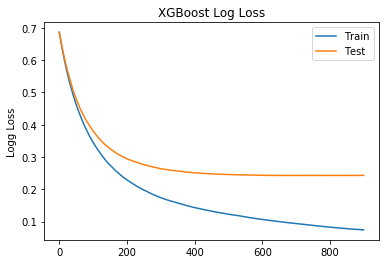

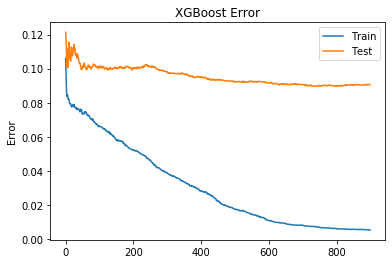

In [441]:
xgb.fit(stack_smote,test.review_score, eval_metric=['error','logloss'], eval_set=eval_set,verbose=True)
predi=xgb.predict(val_meta)
accuracy=metrics.accuracy_score(nlp_val_df.review_score,predi)
results=xgb.evals_result()
epochs=len(results['validation_0']['error'])
x_axis=range(0,epochs)
import matplotlib.pyplot as plt
fig, ax=plt.subplots()
ax.plot(x_axis,results['validation_0']['logloss'],label='Train')
ax.plot(x_axis,results['validation_1']['logloss'],label='Test')

ax.legend()
plt.ylabel('Logg Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax=plt.subplots()
ax.plot(x_axis,results['validation_0']['error'],label='Train')
ax.plot(x_axis,results['validation_1']['error'],label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()
plt.show()


In [486]:
# #900 trees
# xgb.fit(stack_smote,test.review_score, early_stopping_rounds=90,eval_metric=['error','logloss'], eval_set=eval_set,verbose=True)
# predi=xgb.predict(val_meta)
# accuracy=metrics.accuracy_score(nlp_val_df.review_score,predi)
# results=xgb.evals_result()
# epochs=len(results['validation_0']['error'])
# x_axis=range(0,epochs)
# import matplotlib.pyplot as plt
# fig, ax=plt.subplots()
# ax.plot(x_axis,results['validation_0']['logloss'],label='Train')
# ax.plot(x_axis,results['validation_1']['logloss'],label='Test')

# ax.legend()
# plt.ylabel('Logg Loss')
# plt.title('XGBoost Log Loss')
# plt.show()

# fig, ax=plt.subplots()
# ax.plot(x_axis,results['validation_0']['error'],label='Train')
# ax.plot(x_axis,results['validation_1']['error'],label='Test')
# ax.legend()
# plt.ylabel('Error')
# plt.title('XGBoost Error')
# plt.show()
# plt.show()


[0]	validation_0-error:0.105982	validation_0-logloss:0.686348	validation_1-error:0.121368	validation_1-logloss:0.686435
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 90 rounds.
[1]	validation_0-error:0.097879	validation_0-logloss:0.68002	validation_1-error:0.117187	validation_1-logloss:0.680857
[2]	validation_0-error:0.087226	validation_0-logloss:0.673635	validation_1-error:0.114077	validation_1-logloss:0.674739
[3]	validation_0-error:0.083948	validation_0-logloss:0.667235	validation_1-error:0.100675	validation_1-logloss:0.668414
[4]	validation_0-error:0.083675	validation_0-logloss:0.661274	validation_1-error:0.105929	validation_1-logloss:0.663102
[5]	validation_0-error:0.084494	validation_0-logloss:0.655463	validation_1-error:0.110003	validation_1-logloss:0.657944
[6]	validation_0-error:0.084403	validation_0-logloss:0.649529	validation_1-error:0.100568	validation_1-logloss:0.651

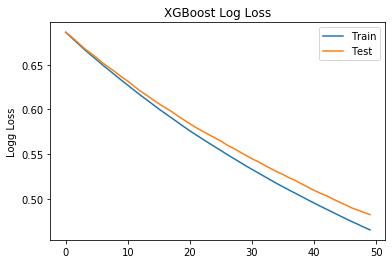

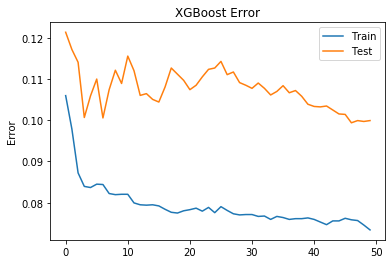

In [487]:
xgb.fit(stack_smote,test.review_score, early_stopping_rounds=90,eval_metric=['error','logloss'], eval_set=eval_set,verbose=True)
predi=xgb.predict(val_meta)
accuracy=metrics.accuracy_score(nlp_val_df.review_score,predi)
results=xgb.evals_result()
epochs=len(results['validation_0']['error'])
x_axis=range(0,epochs)
import matplotlib.pyplot as plt
fig, ax=plt.subplots()
ax.plot(x_axis,results['validation_0']['logloss'],label='Train')
ax.plot(x_axis,results['validation_1']['logloss'],label='Test')

ax.legend()
plt.ylabel('Logg Loss')
plt.title('XGBoost Log Loss')
plt.show()

fig, ax=plt.subplots()
ax.plot(x_axis,results['validation_0']['error'],label='Train')
ax.plot(x_axis,results['validation_1']['error'],label='Test')
ax.legend()
plt.ylabel('Error')
plt.title('XGBoost Error')
plt.show()
plt.show()


In [545]:
import xgboost as xgb
xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [546]:
xgb.fit(stack_smote,test.review_score)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=40, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [547]:
xgb.score(stack_smote,test.review_score)

0.9237002640444323

In [548]:
pred=xgb.predict(val_meta)

In [551]:
print(metrics.confusion_matrix(pred,nlp_val_df.review_score))

[[2037  386]
 [ 583 6321]]


In [1]:
fpr, tpr, thresholds = roc_curve(pred,nlp_val_df.review_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

NameError: name 'roc_curve' is not defined

In [2]:
label={}
for i in nlp_df.review_score:
    if i<=2.5:
        label[i]=0 #negative
    elif i>=2.5:
        label[i]=1 #positive

NameError: name 'nlp_df' is not defined

In [636]:
nlp_df.review_score=nlp_df.review_score.map(label)

In [643]:
nlp_df.reset_index(inplace=True)

In [644]:
nlp_df.drop('index',axis=1,inplace=True)

In [645]:
senti_score=nlp_df.review_score

In [651]:
senti_score.rename(columns=({'review_score':'senti_score'}))

0        1
1        1
2        1
3        1
4        1
        ..
36571    0
36572    1
36573    1
36574    0
36575    1
Length: 36576, dtype: int64

In [655]:
senti_score.name='senti_score'

In [656]:
sent=pd.concat([sent,senti_score],axis=1)

In [658]:
sent.drop('review_score',axis=1,inplace=True)

In [659]:
sent

,order_id,review_comment_message,n_tidy,senti_score
0,9ed40c1d290b912f4cd6594bd495b5fb,produto bom e chegou antes do prazo previsto.e...,produto bom e chegar antar do prazo previstoes...,1
1,8828c448621cb6894c87c5c2be785309,dentro do prazo\r\n,dentro do prazo,1
2,ce3c0e0e8ff8199031c7539eaac530e4,boa,bom,1
3,e3447938231fb6ba2fee0231b51eca59,"produto muito bonito, chegou no prazo correto ...",produto muito bonito chegar o prazo corretar p...,1
4,e87af6f598445282ba3662fc3cc5c3dc,entrega rapidinha.,entregar rapidinha,1
...,...,...,...,...
36571,a0b44209913b27635b5d9813244b7f87,bom dia!\r\npaguei por duas toalhas e so receb...,bom dia pagar por dois toalha e so receber uma...,0
36572,4830bd8fff96f1bb97dd5db5220f4817,produto correto e entregue no prazo,produto corretar e entregar o prazo,1
36573,8003335035c9770dd19bb3906577ae60,muito bom!!!\r\nfiquei espantado com a rapidez,muito bom ficar espantar com o rapidez,1
36574,993f3fc78c8cdf418bd5b0f7cfffcaa9,pensei que a mochila fosse um material mais re...,pensar que o mochila ser um material mais resi...,0


In [660]:
Senti_df=sent.loc[:,['n_tidy','senti_score']]

In [661]:
train, test = train_test_split(Senti_df, test_size=0.3, random_state = 1)


In [662]:
test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['n_tidy']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['n_tidy']), axis=1).values

X_train_word_average = word_averaging_list(model,train_tokenized)
X_test_word_average = word_averaging_list(model,test_tokenized)

In [663]:
def get_best_model(estimator, params_grid={}):
    from sklearn.model_selection import GridSearchCV

    model = GridSearchCV(estimator = estimator,param_grid = params_grid,cv=3, scoring="accuracy", n_jobs= -1)
    model.fit(X_train_word_average,train.senti_score)
    print('\n--- Best Parameters -----------------------------')
    print(model.best_params_)
    print('\n--- Best Model -----------------------------')
    best_model = model.best_estimator_
    print(best_model)
    return best_model

In [664]:
rf = RandomForestClassifier(random_state=3)
parameters={'n_estimators':[100],
'max_depth':[10],
'min_samples_split':[11]}
clf_rf= get_best_model(rf,parameters)


--- Best Parameters -----------------------------
{'max_depth': 10, 'min_samples_split': 11, 'n_estimators': 100}

--- Best Model -----------------------------
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)


In [665]:
rf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [666]:
rf.fit(X_train_word_average,train.senti_score)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [667]:
rf.score(X_train_word_average,train.senti_score)

0.9198922001327969

In [668]:
nlp_pred=rf.predict(X_test_word_average)

In [670]:
print(metrics.classification_report(test.senti_score,nlp_pred))

              precision    recall  f1-score   support

           0       0.76      0.81      0.78      3090
           1       0.92      0.90      0.91      7883

    accuracy                           0.87     10973
   macro avg       0.84      0.86      0.85     10973
weighted avg       0.88      0.87      0.88     10973



In [672]:
from sklearn.linear_model import LogisticRegression

In [673]:
lg = LogisticRegression(random_state=3)
parameters = {'C':[0.8,0.9,1],
'penalty':['l1','l2']}
clf_lg = get_best_model(lg,parameters)


--- Best Parameters -----------------------------
{'C': 1, 'penalty': 'l2'}

--- Best Model -----------------------------
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [675]:
lg =LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [676]:
lg.fit(X_train_word_average,train.senti_score)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=3, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [677]:
lg.score(X_train_word_average,train.senti_score)

0.8468148263875327

In [678]:
lg_pred=lg.predict(X_test_word_average)

In [679]:
print(metrics.classification_report(test.senti_score,lg_pred))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      3090
           1       0.90      0.89      0.90      7883

    accuracy                           0.85     10973
   macro avg       0.81      0.81      0.81     10973
weighted avg       0.85      0.85      0.85     10973



In [680]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[5,6,7],
'p':[1,2],
'weights':['uniform','distance']}
clf_knn = get_best_model(knn,parameters)


--- Best Parameters -----------------------------
{'n_neighbors': 7, 'p': 2, 'weights': 'distance'}

--- Best Model -----------------------------
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='distance')


In [681]:
knn=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='distance')

In [682]:
knn.fit(X_train_word_average,train.senti_score)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='distance')

In [683]:
knn.score(X_train_word_average,train.senti_score)

0.9957036284810373

In [684]:
knn_pred=knn.predict(X_test_word_average)

In [685]:
print(metrics.classification_report(test.senti_score,knn_pred))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80      3090
           1       0.93      0.91      0.92      7883

    accuracy                           0.88     10973
   macro avg       0.85      0.86      0.86     10973
weighted avg       0.89      0.88      0.88     10973



In [694]:
import xgboost as xgb
xgb = xgb.XGBClassifier()
parameters={'n_estimators':[1100],
'learning_rate':[0.03,0.05,0.07,0.09],
'max_depth':[3,4,5,6],
'min_child_weight':[1],
'subsample':[0.8], 
'colsample_bytree':[0.3,0.4,0.5]}
clf_xgb = get_best_model(xgb,parameters)  


--- Best Parameters -----------------------------
{'colsample_bytree': 0.4, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1100, 'subsample': 0.8}

--- Best Model -----------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)


In [695]:
import xgboost as xgb
xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [696]:
xgb.fit(X_train_word_average,train.senti_score)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0,
              learning_rate=0.03, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [697]:
xgb.score(X_train_word_average,train.senti_score)

0.9767605358747021

In [698]:
xgb_pred=xgb.predict(X_test_word_average)

In [699]:
print(metrics.classification_report(test.senti_score,xgb_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      3090
           1       0.93      0.92      0.93      7883

    accuracy                           0.89     10973
   macro avg       0.87      0.87      0.87     10973
weighted avg       0.90      0.89      0.90     10973



In [701]:
metrics.confusion_matrix(test.senti_score,xgb_pred)

array([[2537,  553],
       [ 600, 7283]], dtype=int64)

In [553]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_curve, auc

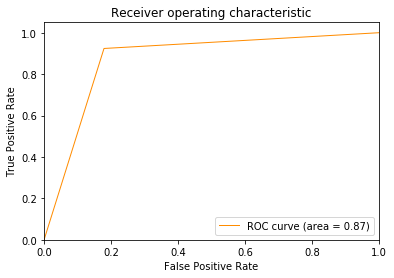

In [708]:
fpr, tpr, thresholds = roc_curve(test.senti_score,xgb_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()